In [ ]:
 #librerie
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from google.colab import drive
from scipy import integrate
from time import sleep
from scipy.optimize import curve_fit

from os import listdir
from os.path import isfile, join
import os

import warnings

import sys
from termcolor import colored, cprint

from tqdm.notebook import tqdm

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1ua48CjVOzBdmEd6bliGTtTF-tvcDCUhU' />
</figure>

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
###########################################
#                                         #
#    CHANGE ONLY THIS CELL IN THE CODE    #
#                                         #
###########################################

data_dir_comp="/content/drive/MyDrive/Lab HPGE/Data/Compass"
data_dir="/content/drive/MyDrive/Lab HPGE/Data"
source="/Ba133"
detector="/Ge"
threshold_caen="12"

downsampling_GE=8

In [ ]:
threshold="_THR_"+threshold_caen

path_to_plots="/content/drive/MyDrive/Lab HPGE/Data/Compass/Plots"+detector+"/"

path_to_simulations=data_dir+"/Simulations"
path_to_calibration=data_dir_comp+detector+"/Calibration"

nome_file_no_ext=source+threshold
nome_file_ext=nome_file_no_ext+".root"
txt_file_name_of_run=nome_file_no_ext+"_all_integrals.txt"

if detector[1:]=="Ge":
    path_to_directory=data_dir_comp+detector+source  # do not change this. Change the part above
elif detector[1:]=="NaI":
    path_to_directory=data_dir_comp+detector+source        # do not change this. Change the part above


def gaussian_plus_bkg(x, N, mu,sigma,h,b,c):
    return N * np.exp(-0.5*((x-mu)/sigma)**2)+h+b*x+c*x**2
def gaussianh(x, N, mu,sigma,h):
    return N * np.exp(-0.5*((x-mu)/sigma)**2)+h

def linear(x, m, q):
  return m*x+q

def parabolic(x, a, b,c):
  return a*x**2+b*x+c

def parabolic_no_q(x, a, b):
  return a*x**2+b*x


def Chi2(oss,real,sigma2):
  chi=0
  for i in range(len(oss)):
    chi+=(oss[i]-real[i])**2/sigma2[i]
  return chi

def Chi2_rid(oss,real,sigma2):
  chi=0
  for i in range(len(oss)):
    chi+=(oss[i]-real[i])**2/sigma2[i]
  return chi/len(oss)

def gaussian(x, N, mu,sigma):
    return N * np.exp(-0.5*((x-mu)/sigma)**2)

def fano(x,S,n):
    #eps=2.96e-3
    return S/x+(n/x)**2

def multiplot(sources,thresholds,date,plot):
  plt.figure(figsize=(25,9))
  total=0
  for source,thr,data in zip(sources,thresholds,date):
    plt.hist(calibration_data[info[source+thr]],bins=info[source+"_bins"],range=info[source+"_range"],alpha=0.8,histtype="step",label=data+" ("+str(len(calibration_data[info[source+thr]]))+") ")
    print(source+"_"+thr+" :",len(calibration_data[info[source+thr]]))
    total+=len(calibration_data[info[source+thr]])
  plt.legend(fontsize=14)
  plt.yscale("log")
  plt.xlim(info[source+"_range"][0],info[source+"_range"][1])
  plt.title("Superimposition of multiple data taken in different days",fontsize=25)
  binwidth=(info[source+"_range"][1]-info[source+"_range"][0])/info[source+"_bins"]
  plt.xlabel("Uncalibrated scale",fontsize=16)
  plt.ylabel("Counts per bin [binwidth = {:.0f}]".format(binwidth),fontsize=16)
  if plot:
    plt.savefig(path_to_plots+"Unc_spectrum_"+source+"_"+detector_to_calibrate+".png")
  plt.show()
  print("Total numb of events: ",total)

  plt.figure(figsize=(25,9))
  stack=[]
  labels=[]
  for source,thr in zip(sources,thresholds):
    stack.append(calibration_data[info[source+thr]])
    labels.append(source+"_"+thr)
  plt.hist(stack,bins=info[source+"_bins"],range=info[source+"_range"],alpha=0.8,histtype="step",label=labels,stacked=True)

  plt.legend(fontsize=14)
  plt.yscale("log")
  plt.show()

# Main Function

def color_title(labels, colors, textprops = {'size':'large'}, ax = None, y = 1.013,
               precision = 10**-2):

    "Creates a centered title with multiple colors. Don't change axes limits afterwards."

    if ax == None:
        ax = plt.gca()

    plt.gcf().canvas.draw()
    transform = ax.transAxes # use axes coords

    # initial params
    xT = 0 # where the text ends in x-axis coords
    shift = 0 # where the text starts

    # for text objects
    text = dict()

    while (np.abs(shift - (1-xT)) > precision) and (shift <= xT) :
        x_pos = shift

        for label, col in zip(labels, colors):

            try:
                text[label].remove()
            except KeyError:
                pass

            text[label] = ax.text(x_pos, y, label,
                        transform = transform,
                        ha = 'left',
                        color = col,
                        **textprops)

            x_pos = text[label].get_window_extent()\
                   .transformed(transform.inverted()).x1

        xT = x_pos # where all text ends

        shift += precision/2 # increase for next iteration

        if x_pos > 1: # guardrail
            break

warnings.filterwarnings("ignore")

In [ ]:
#!apt-get install git dpkg-dev cmake g++ gcc binutils libx11-dev libxpm-dev libxft-dev libxext-dev tar gfortran subversion
#IF IT  DOESN'T WORK UNCOMMENT LINE ABOVE


import sys
sys.path.append(path_to_simulations+"/root_build/")
sys.path.append(path_to_simulations+"/root_build/bin/")
sys.path.append(path_to_simulations+"/root_build/include/")
sys.path.append(path_to_simulations+"/root_build/lib/")
import ctypes
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libCore.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libThread.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libRIO.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libNet.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libImt.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libTree.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libMathCore.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libMatrix.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libHist.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libGraf.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libGpad.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libGraf3d.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libMultiProc.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libTreePlayer.so')

import ROOT

Welcome to JupyROOT 6.14/04


In [ ]:
try:
    first_run = ["/"+file_name for file_name in listdir(path_to_directory) if isfile(join(path_to_directory, file_name)) and file_name[:-5]==nome_file_no_ext[1:] ]
    len_file_name=len(nome_file_no_ext[1:])
    files_name=["/"+file_name for file_name in listdir(path_to_directory) if first_run[0][1:-5]==file_name[0:len_file_name]]
    #integrals_files_name=[name[:-5]+".txt" for name in files_name]
    print("Files of this run with threshold: ",threshold," are: \n")
    ind=0
    for file_n in files_name:
      print("\t\t\t" ,ind,") \t",file_n)
      ind+=1
except:
    print("Folder not found!. Check if the values two cells above are correct.")

Files of this run with threshold:  _THR_12  are: 

			 0 ) 	 /Ba133_THR_12.root
			 1 ) 	 /Ba133_THR_12_1.root
			 2 ) 	 /Ba133_THR_12_2.root


In [ ]:
flag_to_save_waveform=1



integrals_values=[]

sat_events_index=[]

if detector[1:]=="NaI":
  threshold_event=2000   #2500
elif detector[1:]=="Ge":
  threshold_event=3

saturation_value=16383
baseline_mean=2492

j=0
z=0

# estrapolating data
for file_name_of_run in tqdm(files_name):
  all_events=[]
  all_events_normal=[]
  all_gaussians=[]
  tmp=[]
  samples_axis_length={}
  numb_of_events_each_run={}

  print("\n\nStart working on: ",file_name_of_run)
  file_sim = ROOT.TFile.Open(path_to_directory+file_name_of_run,"READ")
  data_root=file_sim.Get("Data_R")
  numb_events=data_root.GetEntries() #numero eventi
  print("There are a total of: ",numb_events," events in this run!")
  print("Start extrapolating data.. ")
  for event in tqdm(data_root):
    single_event=event.Samples  #evento per evento
    if detector[1:]=="Ge":
      for i in range(0,len(single_event),downsampling_GE): #1 point every downsampling_GE points
        tmp.append(single_event[i])

      if max(tmp)==saturation_value: # se è saturato...
        x_axis=np.linspace(0,len(tmp)*downsampling_GE,len(tmp))  # asse x che segue il downsampling
        index_axis=np.arange(0,len(tmp),1)
        tmp=np.array(tmp)
        sat_events_index.append(j) #segno gli indici degli array che sono saturati


        # nel try except vedo la saturazione dove sta sull'asse x e salvo gli indici dove c'è la saturazione
        try:
          sat_value=np.argmax(tmp)[0]
          ind_sat=[i for i in index_axis if tmp[i]==saturation_value]
          ind_sat=np.array(ind_sat)
          init_vals = [saturation_value,x_axis[round((ind_sat[0]+ind_sat[-1])/2)] ,3*len(ind_sat)]  # for [N,mu, wid]
        except:
          sat_value=np.argmax(tmp)
          ind_sat=[i for i in index_axis if tmp[i]==saturation_value]
          ind_sat=np.array(ind_sat)
          init_vals = [saturation_value,x_axis[round((ind_sat[0]+ind_sat[-1])/2)] ,2*downsampling_GE]  # for [N,mu, wid]
         # print(ind_sat)
        best_vals, covar = curve_fit(gaussian, x_axis, tmp,p0=init_vals) #fitto

        #print(ind_sat[0]) debugging

        # sistemo i famosi left right e la parte da cambiare con la gaussiana fittata

        left_ind=index_axis[:ind_sat[0]]
        gaussian_event=gaussian(x_axis[ind_sat],*best_vals)
        gaussian_total=gaussian(x_axis,*best_vals)
        right_ind=index_axis[ind_sat[-1]+1:]
        #print(len(left_ind))
        left=tmp[left_ind]
        right=tmp[right_ind]

        while (gaussian_event[0]<tmp[ind_sat[0]]):
          gaussian_event+=50


        #salvo le cose importanti
        fitted_event=np.empty(len(left)+len(gaussian_event)+len(right))
        np.concatenate((left,gaussian_event,right),out=fitted_event)
        #plt.plot(,np.concatenate(left,gaussian_event,right),)
        #fitted_event=gaussian(x_axis,*best_vals)

        if flag_to_save_waveform==1:
          all_events.append(fitted_event)
          all_gaussians.append(gaussian_total)      #servono per plottare le waveform
          all_events_normal.append(tmp)

        # questo try except è perchè alcune volte smadonna quindi bho
        try:
          integrals_values.append(integrate.trapz(fitted_event,x_axis))
        except:
          z+=1



      else:
        if flag_to_save_waveform==1:
          all_events.append(tmp)
          all_gaussians.append(0)
          all_events_normal.append(tmp)
        x_axis=np.linspace(0,len(tmp)*downsampling_GE,len(tmp))
        integrals_values.append(integrate.trapz(tmp,x_axis))

      tmp=[]

      j+=1
      #solo per debuggare
      if flag_to_save_waveform==1:
        if(j==5000):
          break


#      numb_of_events_each_run[file_name_of_run]=numb_events
#      samples_axis_length[file_name_of_run]=np.linspace(0,len(all_events[-1]),downsampling_GE)
    elif detector[1:]=="NaI":
      for i in range(len(single_event)):
        tmp.append(single_event[i])
      if max(tmp) < threshold_event:
        if flag_to_save_waveform==1:
          all_events.append(tmp)
        pass
      else:
        tmp=np.array(tmp)-baseline_mean #min(tmp)
        all_events.append(tmp)
        x_axis=np.linspace(0,len(tmp),len(tmp))
        integrals_values.append(integrate.trapz(tmp,x_axis))
        if flag_to_save_waveform==1:
          all_events.append(tmp)

      tmp=[]
#      numb_of_events_each_run[file_name_of_run]=numb_events
#      samples_axis_length[file_name_of_run]=np.linspace(0,len(all_events[-1]),1)

    else:
      print("Detector not valid.")
  print("Number of saturated events: ",len(sat_events_index),"    [",round(len(sat_events_index)/numb_events*100,2),"%] ")

  print("...Finished! Passing to next file. \n")
  if flag_to_save_waveform==1:
     break # per fare solo un file invece che multipli

  0%|          | 0/3 [00:00<?, ?it/s]



Start working on:  /Ba133_THR_12.root
There are a total of:  119791  events in this run!
Start extrapolating data.. 


0it [00:00, ?it/s]

Number of saturated events:  17     [ 0.01 %] 
...Finished! Passing to next file. 



639


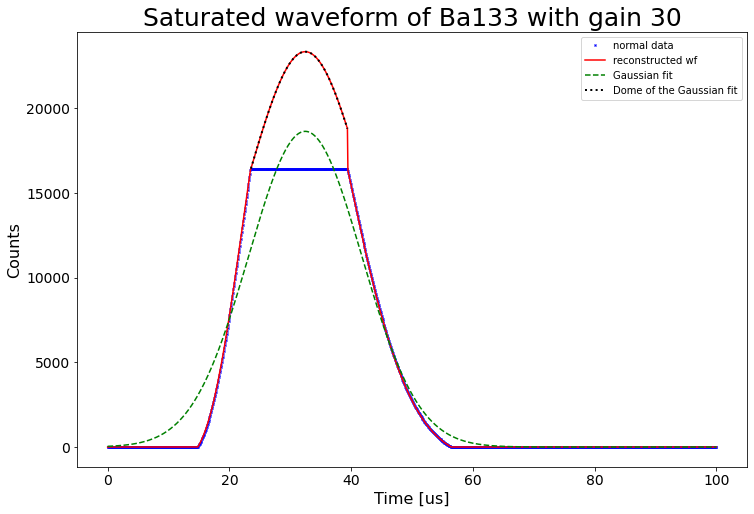

In [ ]:


#######################################################
# SOLO PER PLOTTARE LE WAVEFORM MA VA SISTEMATO SOPRA #
#######################################################


plt.figure(figsize=(12,8))
sat_plot=True

event_index=20
tmp=0

#for index in sat_events_index:
#  if max(all_events[index])>tmp:
#    event_index=index
#    tmp=max(all_events[index])

if sat_plot:
  #event_index=sat_events_index[np.random.randint(0,len(sat_events_index))]
  event_index=sat_events_index[1]

if detector[1:]=="Ge":
  event_normal=all_events_normal[event_index]
  event_reconstr=all_events[event_index]
  gauss=all_gaussians[event_index]


  plt.title("Saturated waveform of {:s} with gain {:d}".format(source[1:],30),fontsize=25)
  plt.xlabel("Time [us]",fontsize=16)
  plt.ylabel("Counts",fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)


  x_ax=np.linspace(0,event_normal.shape[0]*downsampling_GE,event_normal.shape[0])/100

  index_ax=np.arange(0,event_normal.shape[0],1)
  ind_sat=[i for i in index_ax if event_normal[i]==saturation_value]
  gaussian_event=gauss[ind_sat]


  plt.plot(x_ax,event_normal,ls="",marker="x",markersize=2,color="blue",label="normal data")
  plt.plot(x_ax,event_reconstr,color="red",label="reconstructed wf",lw=1.5)
  plt.plot(x_ax,gauss,color="green",label="Gaussian fit",ls="--")
  riferimento=gaussian_event[0]
  tmp=gauss.copy()
  while (riferimento<event_normal[ind_sat[0]]):
    gauss+=50
    riferimento+=50
  plt.plot(x_ax[ind_sat],gauss[ind_sat],color="black",label="Dome of the Gaussian fit",ls=":",lw=2)
  gauss=tmp
  plt.legend()
  #plt.savefig(path_to_plots+"Gaussian_Waveform_non_saturated_superposition.png")

  print(event_index)
  #plt.xlim(5500,6000)
elif detector[1:]=="NaI":
  index_valid=[]
  for index in range(len(all_events)):
    if max(all_events[index])<10:
      pass
    else:
      index_valid.append(index)
  event_index=index_valid[17]
  event=np.array(all_events[event_index])#+2500
  x_axis=np.linspace(0,len(event),len(event))/80

  plt.plot(x_axis,event,ls="",marker="x",markersize=5,color="red")
  plt.plot(x_axis,event,marker="x",markersize=2,color="blue")


  plt.title("Waveform of {:s} with NaI".format(source[1:]),fontsize=25)
  plt.xlabel("Time [us]",fontsize=16)
  plt.ylabel("Counts",fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  #plt.xlim(0.1,0.9)
  #plt.savefig(path_to_plots+"NaI_waveform_2.png")

# **Run from here if txt files with energies are already present**

In [ ]:

#change this line

overwrite_flag=0 # 0 to leave the file as it is   not 0 to overwrite the file already present

##############################################################################################





files_in_directory=["/"+file_name for file_name in listdir(path_to_calibration) if isfile(join(path_to_calibration, file_name))]


if txt_file_name_of_run in files_in_directory:
  print("Already present")
  if overwrite_flag!=0:
    print("Do you want to overwrite the file?")
    answer=input()
    if answer=="y" or answer=="yes" or answer=="Y" or answer=="ye" or answer=="YES":
      os.remove(path_to_calibration+txt_file_name_of_run)
      np.savetxt(path_to_calibration+txt_file_name_of_run,integrals_values)
      print("File saved")
    else:
      print("File not changed.")
else:
  np.savetxt(path_to_calibration+txt_file_name_of_run,integrals_values)
  print("File saved")

Already present
Do you want to overwrite the file?
y
File saved


In [ ]:
detector_to_calibrate="/Ge"
path_to_calibration=data_dir_comp+detector_to_calibrate+"/Calibration"

######################################################################################

print("Available sources + thresholds are:\n")
for file_name in listdir(path_to_calibration):
  if file_name[-3:]=="txt":
    print("\t ",file_name[:-18])

Available sources + thresholds are:

	  Na22_THR_20
	  Ba133_THR_2
	  Ba133_THR_3
	  Co60_THR_15
	  Co60_THR_9
	  Cs137_THR_12
	  Cs137_THR_9
	  Ba133_THR_9
	  Ba133_THR_10
	  Ba133_THR_11
	  Ba133_THR_12
	  Co60_THR_20
	  Co60_THR_10
	  Ba133_THR_5
	  Na22_THR_5
	  Cs137_THR_30000
	  Ba133_THR_30000
	  Cs137_THR_10000
	  Cs137_THR_3
	  Na22_THR_10000
	  Co60_THR_10000
	  Ba133_THR_10000
	  Ba133_THR_10001


In [ ]:
#Change these 2 lines below to add new sources and the respective thresholds
#sources_to_calibrate_base=["Cs137","Ba133","Na22","Co60","Am241","Co60"] #            ["Ba133","Co60"]    Calibration data for the germanium
#thresholds_to_calibrate_base=["30","30","80","31","30","150"]       #            ["5","20"]

sources_to_calibrate_base=["Ba133"]  # Calibration data for the NaI
thresholds_to_calibrate_base=["10000"]
date_to_calibrate_base={"13-05","19-05","08-06"}


#sources_to_calibrate_base=["Na22","Ba133"] #            ["Ba133","Co60"]    Calibration data for the germanium
#thresholds_to_calibrate_base=["5","5"]

detector_to_calibrate="/NaI"

mix=0
#########################################################################################


path_to_calibration=data_dir_comp+detector_to_calibrate+"/Calibration"


sources_to_calibrate=["/"+source_to_calibrate for source_to_calibrate in sources_to_calibrate_base]
thresholds_to_calibrate=["_THR_"+threshold_to_calibrate for threshold_to_calibrate in thresholds_to_calibrate_base]

calibration_info=zip(sources_to_calibrate,thresholds_to_calibrate)

calibration_data=[]

for SOURCE,THRESHOLD in calibration_info:
  nomefile=path_to_calibration+SOURCE+THRESHOLD+"_all_integrals.txt"
  f=open(nomefile,"r")
  lines=f.readlines() #leggo linee del file
  colonna1=[]

  for riga in lines:
    colonna1.append(riga.split()[0])
  f.close()

  all_integrals_values = np.asarray(colonna1, dtype=np.float64)

  calibration_data.append(all_integrals_values)

txt_file_name_of_run=sources_to_calibrate_base[0]+"_THR_"+"12001_all_integrals.txt"

if mix==1:
  mix_array=[integral for file_data in calibration_data for integral in file_data]
  np.savetxt(path_to_calibration+"/"+txt_file_name_of_run,mix_array)

#removing memory
list_event_array=0
non_noise_events_plus_baseline=0

12.933333333333334





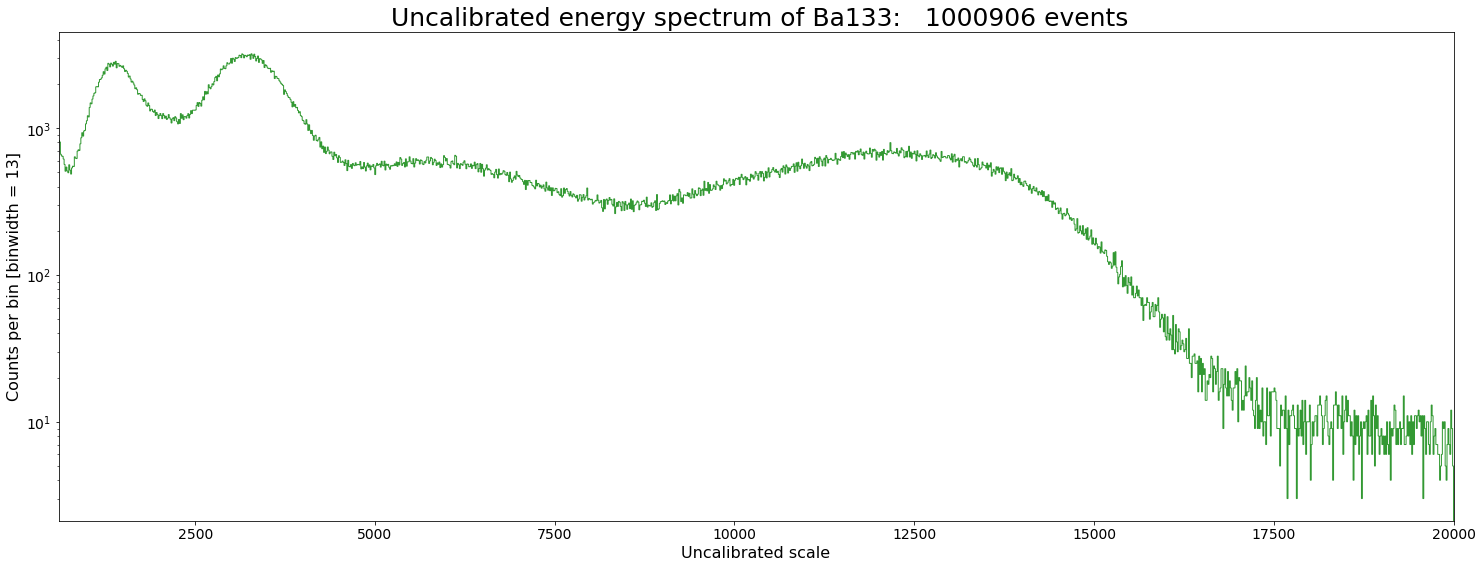

In [ ]:
source_to_plot="Ba133" #CHANGE ONLY THIS
thr_to_plot="10000"
gain=30
detector_to_calibrate="NaI"

multiplot_flag=0


#change these settings below

info={}
peaks={}

#NAI
if detector_to_calibrate=="NaI":

  info={"Ba133_bins":1500,"Ba133_range":(600,20000),"Ba133_range_cal":(0,600),"Ba133_col":"green",
        "Cs137_bins":2000,"Cs137_range":(500,30000),"Cs137_range_cal":(0,900),"Cs137_col":"blue",
        "Na22_bins":800, "Na22_range" :(600,80000),"Na22_range_cal":(0,1400),"Na22_col" :"red",
        "Co60_bins":800,"Co60_range" :(600,70000),"Co60_range_cal":(0,1600),"Co60_col" :"orange",
        "Am241_bins":500,"Am241_range":(600,5000),"Am241_range_cal":(0,600),"Am241_col":"purple"}
  j=0
  for source,thr in zip(sources_to_calibrate_base,thresholds_to_calibrate_base):
    info[source+thr]=j
    j+=1

  peaks={"Ba133_unc":[1450,3250],
        "Ba133_cal": [30.973,80.9971],#kev

        "Cs137_unc": [1500,20000],    #3330
        "Cs137_cal": [32.194,661.657],#75

        "Co60_unc": [38000,42000],
        "Co60_cal": [1173.237,1332.501],

        "Na22_unc": [19000],
        "Na22_cal": [511.001],#kev

        "Am241_unc":[2200],    ## QUESTI SONO COPIA E INCOLLLA DEL BARIO SOLO PER VEDERE L'ISTOGRAMMA
        "Am241_cal": [59.301]}#kev

#GE
elif detector_to_calibrate=="Ge":
  if gain==30:
    info={#"Ba133_bins":1500,"Ba133_range":(00,3000000),"Ba133_range_cal":(0,400),"Ba133_col":"green",       # gain a 10
          "Ba133_bins":1800,"Ba133_range":(1000,30000000),"Ba133_range_cal":(29,400),"Ba133_col":"green",
          "Cs137_bins":2000,"Cs137_range":(1000,60000000),"Cs137_range_cal":(29,700),"Cs137_col":"blue",
          "Na22_bins":1800,"Na22_range":(1000,30000000),"Na22_range_cal":(0,1300),"Na22_col":"red",
          "Co60_bins":500,"Co60_range":(1000,80000000)  ,"Co60_range_cal":(0,1600),"Co60_col":"purple",}

    j=0
    for source,thr in zip(sources_to_calibrate_base,thresholds_to_calibrate_base):
      info[source+thr]=j
      j+=1

    peaks={#"Ba133_unc": [1.5e5  , 4e6     , 4.6e6  , 5.8e6   , 6.45e6],                       # gain a 10 (picchi calibrati cancellare da sx fino a raggiungere la stessa lunghezza)
           "Ba133_unc": [0.04e7 ,0.06e7 , 0.18e7 , 0.35e7  , 1.78e7   , 1.98e7  , 2.36e7   , 2.565e7  ],
           "Ba133_cal": [30.973, 34.921 , 53.161 , 80.9971 , 276.398 , 302.853 , 356.017 , 383.851], #kev

            #"Cs137_unc": [4.12e7],                         # gain a  10
            "Cs137_unc": [0.04e7 ,0.061e7 ,  4.6e7],#,3.95e7],
            "Cs137_cal": [31.817 , 36.378 , 661.657],#,661.657],

            "Co60_unc": [2.48e7],#,   2.86e7],
            "Co60_cal": [1173.237],# , 1332.501],

            "Na22_unc": [0.93e7],
            "Na22_cal": [511.001]} #kev
  elif gain==10:
    info={#"Ba133_bins":1500,"Ba133_range":(00,3000000),"Ba133_range_cal":(0,400),"Ba133_col":"green",       # gain a 10
          "Ba133_bins":1200,"Ba133_range":(0,7000000),"Ba133_range_cal":(91,400),"Ba133_col":"green",
          "Cs137_bins":1200,"Cs137_range":(0,14000000),"Cs137_range_cal":(0,700),"Cs137_col":"blue",
          "Na22_bins":800,"Na22_range":(0,30000000),"Na22_range_cal":(93,1300),"Na22_col":"red",
          "Co60_bins":1500,"Co60_range":(0,35000000)  ,"Co60_range_cal":(130,1600),"Co60_col":"purple",}

    j=0
    for source,thr in zip(sources_to_calibrate_base,thresholds_to_calibrate_base):
      info[source+thr]=j
      j+=1

    peaks={"Ba133_unc": [1.5e5  , 3.94e6     , 4.54e6  , 5.74e6   , 6.38e6],                       # gain a 10 (picchi calibrati cancellare da sx fino a raggiungere la stessa lunghezza)
           #"Ba133_unc": [0.04e7 ,0.06e7 , 0.18e7 , 0.37e7  , 1.78e7   , 1.98e7  , 2.38e7   , 2.585e7  ],
           "Ba133_cal": [80.9971 , 276.398 , 302.853 , 356.017 , 383.851], #kev

            #"Cs137_unc": [4.12e7],                         # gain a  10
            "Cs137_unc": [4.6e7],#[0.04e7 ,0.061e7 ,  4.6e7],#,3.95e7],
            "Cs137_cal": [661.657],#[31.817 , 36.378 , 661.657],#,661.657],

            "Co60_unc": [2.48e7,   2.86e7],
            "Co60_cal": [1173.237, 1332.501],

            "Na22_unc": [0.93e7],
            "Na22_cal": [511.001]} #kev


###########################################################################################################
numb_uncal_peaks=0
for source in sources_to_calibrate_base:
  numb_uncal_peaks+=len(peaks[source+"_cal"])


if multiplot_flag==1:
  multiplot(sources_to_calibrate_base,thresholds_to_calibrate_base,thresholds_to_calibrate_base,False)

ticks_peaks=[]
for source in sources_to_calibrate_base:
  for peak in peaks[source+"_unc"]:
    ticks_peaks.append(peak)

#plt.xticks(ticks_peaks,label=ticks_peaks,color="black",rotation=70,fontsize=14)

binwidth=(info[source_to_plot+"_range"][1]-info[source_to_plot+"_range"][0])/info[source_to_plot+"_bins"]
print(binwidth)

if multiplot_flag==0:
  plt.figure(figsize=(25,9))
  plt.hist(calibration_data[info[source_to_plot+thr_to_plot]],bins=info[source_to_plot+"_bins"],color=info[source_to_plot+"_col"],range=info[source_to_plot+"_range"],alpha=0.8,histtype="step")
  plt.yscale("log")
  print("\n\n")

  plt.title(" Uncalibrated energy spectrum of {:s}:   {:d} events".format(source_to_plot,len(calibration_data[info[source_to_plot+thr_to_plot]])),fontsize=25)
  plt.xlabel("Uncalibrated scale",fontsize=16)
  plt.ylabel("Counts per bin [binwidth = {:.0f}]".format(binwidth),fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.xlim(info[source_to_plot+"_range"][0],info[source_to_plot+"_range"][1])

  #plt.savefig(path_to_plots+"Unc_spectrum_Ba133_NaI.png")

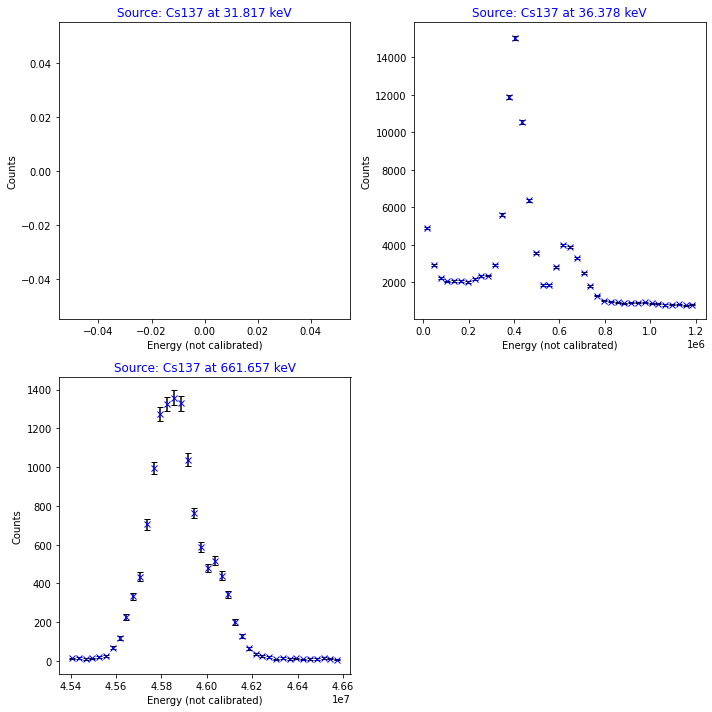

In [ ]:
plt.figure(figsize=(10,10))

n_rows=round((numb_uncal_peaks+0.1)/2.)
#n_rows=3
n_cols=2
k=1


for source,thr in zip(sources_to_calibrate_base,thresholds_to_calibrate_base):
  for Xpeak_unc,Xpeak_cal in zip(peaks[source+"_unc"],peaks[source+"_cal"]):

    histogram=np.histogram(calibration_data[info[source+thr]],bins=info[source+"_bins"],range=info[source+"_range"])
    #grandezze legate ai bin
    value=histogram[0]
    sigma_value=np.sqrt(value)
    center_bins=[0.5*(histogram[1][i]+histogram[1][i+1]) for i in range(len(histogram[1])-1)]
    center_bins=np.array(center_bins)
    i_sx=20
    i_dx=20
    for i in range(len(center_bins)):
        if(center_bins[i] > Xpeak_unc):
            plt.subplot(n_rows,n_cols,k)
            plt.errorbar(center_bins[i-i_sx:i+i_dx],value[i-i_sx:i+i_dx],yerr=np.sqrt(value[i-i_sx:i+i_dx]),fmt="x",color=info[source+"_col"],ecolor="black",capsize=3)
            #plt.plot(center_bins[i-best_i_sx[k-1]:i+best_i_dx[k-1]],value[i-best_i_sx[k-1]:i+best_i_dx[k-1]],ls="",marker="x",markersize=8,color="black")
            plt.title("Source: {:s} at {:s} keV".format(source,str(Xpeak_cal)),color=info[source+"_col"])
            plt.xlabel("Energy (not calibrated)")
            plt.ylabel("Counts")
            x_gauss=np.linspace(center_bins[i-i_sx],center_bins[i+i_dx],1000)
            #init_vals = [value[i],Xpeak_unc ,(center_bins[i+1]-center_bins[i-1]),0,0,0]
            #best_vals_gauss, covar_gauss = curve_fit(gaussian_plus_bkg,center_bins[i-i_sx:i+i_dx],value[i-i_sx:i+i_dx],sigma=np.sqrt(value[i-i_sx:i+i_dx]),p0=init_vals)
            #plt.plot(x_gauss,gaussian_plus_bkg(x_gauss,*best_vals_gauss),color="green")
            #plt.plot(x_gauss,gaussian_plus_bkg(x_gauss,*init_vals),color="red")
            k+=1
            break
plt.tight_layout()
#plt.savefig(path_to_plots+"Gaussian_Fits.png")

In [ ]:
all_mu={}
all_sigmaMu={}

all_sigma={}
all_sigmaSigma={}

all_N={}
all_sigmaN={}

all_H={}
all_sigmaH={}

all_B={}
all_C={}
all_D={}
all_E={}

best_i_sx={}
best_i_dx={}

best_bins={}



for source,thr in zip(sources_to_calibrate_base,thresholds_to_calibrate_base):

  central_bins=info[source+"_bins"]
  bins_at_left=0
  bins_at_right=1

  for Xpeak_unc,Xpeak_cal in zip(peaks[source+"_unc"],peaks[source+"_cal"]):
    err_mu_best=5.
    err_sigma_best=40.
    err_perc_best=100.

    for numb_bins_fit in range(central_bins+bins_at_left,central_bins+bins_at_right):

      histogram=np.histogram(calibration_data[info[source+thr]],bins=numb_bins_fit,range=info[source+"_range"])
      #grandezze legate ai bin
      value=histogram[0]
      sigma_value=np.sqrt(value)
      center_bins=[0.5*(histogram[1][i]+histogram[1][i+1]) for i in range(len(histogram[1])-1)]
      center_bins=np.array(center_bins)
      flag=0


      for i in range(len(center_bins)):
          if(center_bins[i] > Xpeak_unc and flag==0):

            for i_sx in range(4,20):                 # Change the numbers in range:  first one is the min number of bins that the fit has to consider
              for i_dx in range(4,20):               #                               second one is the max number of bins that the fit can consider
                err_mu_perc=10000
                err_sigma_perc=10000
                err_perc=100000
                try:
                  i_baseline=30
                  init_vals = [value[i],Xpeak_unc ,(center_bins[i+1]-center_bins[i-1]),value[i+i_baseline],0,0]
                  best_vals_gauss, covar_gauss = curve_fit(gaussian_plus_bkg,center_bins[i-i_sx:i+i_dx],value[i-i_sx:i+i_dx],sigma=np.sqrt(value[i-i_sx:i+i_dx]),p0=init_vals)
                  err_mu_perc=np.sqrt(covar_gauss[1][1])*100/best_vals_gauss[1]
                  err_sigma_perc=np.sqrt(covar_gauss[2][2])*100/abs(best_vals_gauss[2])
                  err_perc=best_vals_gauss[2]/best_vals_gauss[1]
                except:
                  pass

                #if (err_perc< err_perc_best):                                          # different metrics to find the best fit
                if (err_mu_perc< err_mu_best and err_sigma_perc<err_sigma_best):       #
                  all_mu[source+"_"+str(Xpeak_cal)]=best_vals_gauss[1]
                  all_sigmaMu[source+"_"+str(Xpeak_cal)]=covar_gauss[1][1]

                  all_sigma[source+"_"+str(Xpeak_cal)]=best_vals_gauss[2]
                  all_sigmaSigma[source+"_"+str(Xpeak_cal)]=covar_gauss[2][2]

                  all_N[source+"_"+str(Xpeak_cal)]=best_vals_gauss[0]
                  all_sigmaN[source+"_"+str(Xpeak_cal)]=covar_gauss[0][0]

                  all_H[source+"_"+str(Xpeak_cal)]=best_vals_gauss[3]
                  all_sigmaH[source+"_"+str(Xpeak_cal)]=covar_gauss[3][3]

                  all_B[source+"_"+str(Xpeak_cal)]=best_vals_gauss[4]
                  all_C[source+"_"+str(Xpeak_cal)]=best_vals_gauss[5]
                 #all_D[source+"_"+str(Xpeak_cal)]=best_vals_gauss[6]
                 #all_E[source+"_"+str(Xpeak_cal)]=best_vals_gauss[7]
                  best_i_dx[source+"_"+str(Xpeak_cal)]=i_dx
                  best_i_sx[source+"_"+str(Xpeak_cal)]=i_sx
                  best_bins[source+"_"+str(Xpeak_cal)]=numb_bins_fit

                  err_mu_best=err_mu_perc
                  err_sigma_best=err_sigma_perc
                  err_perc_best=err_perc
                else:
                  pass
            flag=1
    print(source,":  peak at: ",Xpeak_cal,"[keV] \t", "  bins: ",best_bins[source+"_"+str(Xpeak_cal)],"\t    mu: {:.3e}".format(all_mu[source+"_"+str(Xpeak_cal)]),"  \t err_mu {:.4f}[%]: ".format(np.sqrt(all_sigmaMu[source+"_"+str(Xpeak_cal)])*100/all_mu[source+"_"+str(Xpeak_cal)]), "\t sigma {:.3e}  ".format(abs(all_sigma[source+"_"+str(Xpeak_cal)])),"  \t err_sigma {:.3f}[%] ".format(np.sqrt(all_sigmaSigma[source+"_"+str(Xpeak_cal)])*100/abs(all_sigma[source+"_"+str(Xpeak_cal)])))



Cs137 :  peak at:  31.817 [keV] 	   bins:  2000 	    mu: 4.040e+05   	 err_mu 0.2741[%]:  	 sigma 3.601e+04     	 err_sigma 3.374[%] 
Cs137 :  peak at:  36.378 [keV] 	   bins:  2000 	    mu: 6.303e+05   	 err_mu 0.3455[%]:  	 sigma 6.014e+04     	 err_sigma 4.925[%] 
Cs137 :  peak at:  661.657 [keV] 	   bins:  2000 	    mu: 4.584e+07   	 err_mu 0.0067[%]:  	 sigma 8.919e+04     	 err_sigma 3.848[%] 


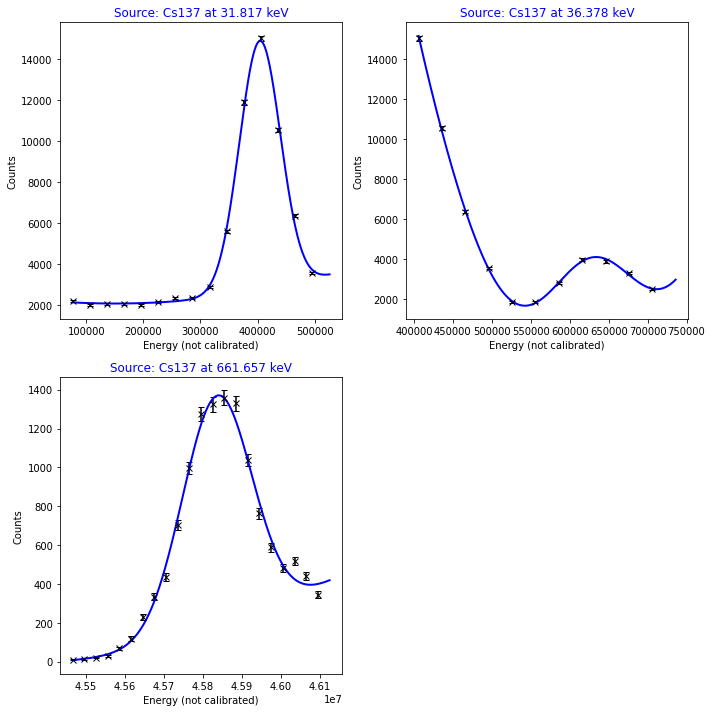

In [ ]:
plt.figure(figsize=(10,10))

n_rows=round((numb_uncal_peaks+0.1)/2.)
#n_rows=3
n_cols=2
k=1


for source,thr in zip(sources_to_calibrate_base,thresholds_to_calibrate_base):
  for Xpeak_unc,Xpeak_cal in zip(peaks[source+"_unc"],peaks[source+"_cal"]):

    histogram=np.histogram(calibration_data[info[source+thr]],bins=best_bins[source+"_"+str(Xpeak_cal)],range=info[source+"_range"])
    #grandezze legate ai bin
    value=histogram[0]
    sigma_value=np.sqrt(value)
    center_bins=[0.5*(histogram[1][i]+histogram[1][i+1]) for i in range(len(histogram[1])-1)]
    center_bins=np.array(center_bins)

    for i in range(len(center_bins)):
        if(center_bins[i] > Xpeak_unc):

            x_gauss=np.linspace(center_bins[i-best_i_sx[source+"_"+str(Xpeak_cal)]],center_bins[i+best_i_dx[source+"_"+str(Xpeak_cal)]],1000)
            plt.subplot(n_rows,n_cols,k)
            plt.errorbar(center_bins[i-best_i_sx[source+"_"+str(Xpeak_cal)]:i+best_i_dx[source+"_"+str(Xpeak_cal)]],value[i-best_i_sx[source+"_"+str(Xpeak_cal)]:i+best_i_dx[source+"_"+str(Xpeak_cal)]],yerr=np.sqrt(value[i-best_i_sx[source+"_"+str(Xpeak_cal)]:i+best_i_dx[source+"_"+str(Xpeak_cal)]]),fmt="x",color="black",ecolor="black",capsize=3)
            #plt.plot(center_bins[i-best_i_sx[k-1]:i+best_i_dx[k-1]],value[i-best_i_sx[k-1]:i+best_i_dx[k-1]],ls="",marker="x",markersize=8,color="black")
            plt.plot(x_gauss,gaussian_plus_bkg(x_gauss,all_N[source+"_"+str(Xpeak_cal)],all_mu[source+"_"+str(Xpeak_cal)],all_sigma[source+"_"+str(Xpeak_cal)],all_H[source+"_"+str(Xpeak_cal)],all_B[source+"_"+str(Xpeak_cal)],all_C[source+"_"+str(Xpeak_cal)]),color=info[source+"_col"],lw=2)
            plt.title("Source: {:s} at {:s} keV".format(source,str(Xpeak_cal)),color=info[source+"_col"])
            plt.xlabel("Energy (not calibrated)")
            plt.ylabel("Counts")
            k+=1
            break
plt.tight_layout()
#plt.savefig(path_to_plots+"Gaussian_Fits_NaI_Ba_Cs_Am.png")

m: 7.18e+04  +/- 4.46e+02    relative:  0.62 %
q: -2.05e+06  +/- 9.47e+04    relative:  4.61 %
Chi squared reduced: 29.390


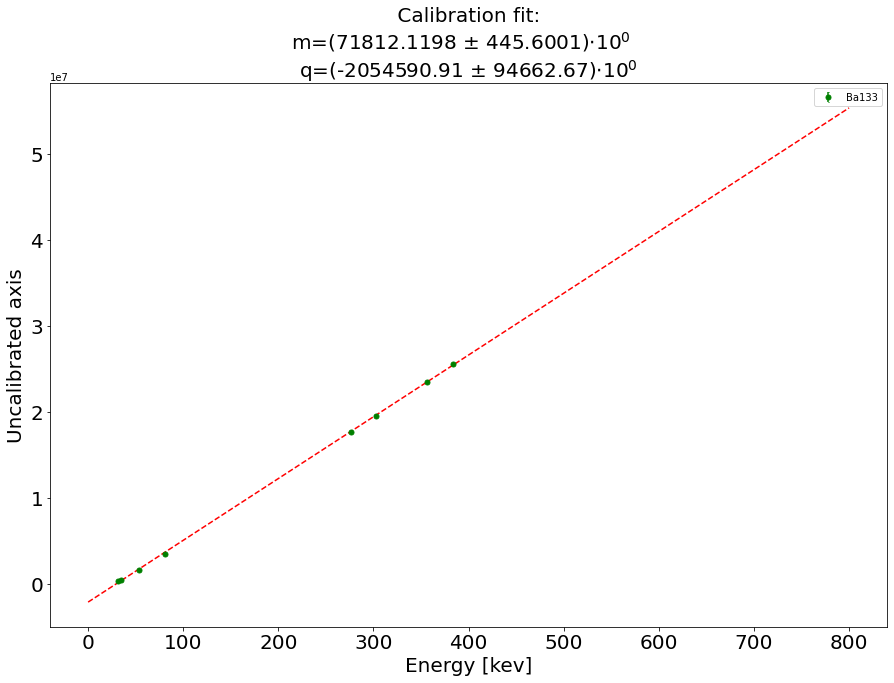

In [ ]:
E_real_peaks=[]

E_unc_Mu= []
E_unc_sigmaMu=[]

E_unc_Sigma= []
E_unc_sigmaSigma=[]

E_cal_sources=[]
E_uncal_sources=[]
E_unc_sigmaMu_sources=[]
E_unc_sigmasigma_sources=[]
E_uncal_sigma_sources=[]

tmp1=[]
tmp2=[]
tmp3=[]
tmp4=[]
tmp5=[]

SOURCES_TO_PLOT_CALIBRATE=sources_to_calibrate_base
#SOURCES_TO_PLOT_CALIBRATE=["Ba133","Cs137","Am241"]

for SOURCE in SOURCES_TO_PLOT_CALIBRATE:
  for xpeak_unc,xpeak_cal in zip(peaks[SOURCE+"_unc"],peaks[SOURCE+"_cal"]):
    tmp1.append(xpeak_cal)
    tmp2.append(all_mu[SOURCE+"_"+str(xpeak_cal)])
    tmp3.append(all_sigmaMu[SOURCE+"_"+str(xpeak_cal)])
    tmp4.append(all_sigmaSigma[SOURCE+"_"+str(xpeak_cal)])
    tmp5.append(abs(all_sigma[SOURCE+"_"+str(xpeak_cal)]))

    E_real_peaks.append(xpeak_cal)

    E_unc_Mu.append(all_mu[SOURCE+"_"+str(xpeak_cal)])
    E_unc_sigmaMu.append(all_sigmaMu[SOURCE+"_"+str(xpeak_cal)])

    E_unc_Sigma.append(abs(all_sigma[SOURCE+"_"+str(xpeak_cal)]))
    E_unc_sigmaSigma.append(all_sigmaSigma[SOURCE+"_"+str(xpeak_cal)])

  E_cal_sources.append(tmp1)
  E_uncal_sources.append(tmp2)
  E_uncal_sigma_sources.append(np.array(tmp5))
  E_unc_sigmaMu_sources.append(tmp3)
  E_unc_sigmasigma_sources.append(tmp4)

  tmp1=[]
  tmp2=[]
  tmp3=[]
  tmp4=[]
  tmp5=[]

E_unc_Mu=np.array(E_unc_Mu)
E_unc_sigmaMu=np.array(E_unc_sigmaMu)

multiplication_cheat=15000

E_unc_Sigma=multiplication_cheat*np.array(E_unc_Sigma)
#E_unc_Sigma=np.array(E_unc_Mu)
E_unc_sigmaSigma=np.array(E_unc_sigmaSigma)

E_real_peaks=np.array(E_real_peaks)




end_range=0
tmp=0
for source in SOURCES_TO_PLOT_CALIBRATE:
  tmp=info[source+"_range_cal"]
  if tmp[1]>end_range:
    end_range=tmp[1]
x=np.linspace(0,end_range+100,5000)
x=np.linspace(0,800,5000)

plt.figure(figsize=(15,10))


for SOURCE,j in zip(SOURCES_TO_PLOT_CALIBRATE,range(len(SOURCES_TO_PLOT_CALIBRATE))):
  plt.errorbar(E_cal_sources[j],E_uncal_sources[j],yerr=np.sqrt(multiplication_cheat*E_uncal_sigma_sources[j]),fmt="o",capsize=0.5,label=SOURCE,markersize=5,c=info[SOURCE+"_col"])
  #plt.plot(E_cal_sources[j],E_uncal_sources[j],marker="x",ls="",label=SOURCE,markersize=20)



linear_bool=True
parabolic_bool=False

if linear_bool:
  #fitting
  init_vals = [1,1]  # for [N,mu, wid]
  best_vals, covar = curve_fit(linear, E_real_peaks,E_unc_Mu,p0=init_vals, sigma=np.sqrt(E_unc_Sigma))
  print("m: {:.2e}  +/- {:.2e}    relative:  {:.2f} %".format(best_vals[0],np.sqrt(covar[0][0]),np.sqrt(covar[0][0])*100/best_vals[0]) )
  print("q: {:.2e}  +/- {:.2e}    relative:  {:.2f} %".format(best_vals[1],np.sqrt(covar[1][1]),np.sqrt(covar[1][1])*100/abs(best_vals[1])) )
  plt.plot(x,linear(x,*best_vals),ls="--",color="red")
  print("Chi squared reduced: {:.3f}".format(Chi2_rid(E_unc_Mu,linear(E_real_peaks,*best_vals),E_unc_Sigma)))
if parabolic_bool:
  #fitting
  init_vals = [1,1,1]  # for [N,mu, wid]
  best_vals, covar = curve_fit(parabolic, E_real_peaks,E_unc_Mu,p0=init_vals, sigma=np.sqrt(E_unc_Sigma))
  print("a: {:.2e}  +/- {:.2e}    relative:  {:.2f} %".format(best_vals[0],np.sqrt(covar[0][0]),np.sqrt(covar[0][0])*100/best_vals[0]) )
  print("b: {:.2e}  +/- {:.2e}    relative:  {:.2f} %".format(best_vals[1],np.sqrt(covar[1][1]),np.sqrt(covar[1][1])*100/abs(best_vals[1])) )
  print("c: {:.2e}  +/- {:.2e}    relative:  {:.2f} %".format(best_vals[2],np.sqrt(covar[2][2]),np.sqrt(covar[2][2])*100/abs(best_vals[2])) )
  plt.plot(x,parabolic(x,*best_vals),ls="--",color="red")
  print("Chi squared reduced: {:.3f}".format(Chi2_rid(E_unc_Mu,parabolic(E_real_peaks,*best_vals),E_unc_Sigma)))


plt.title(" Calibration fit: \n m=({:.4f} $\pm$ {:.4f})$\cdot 10^0$    \nq=({:.2f} $\pm$ {:.2f})$\cdot 10^0$".format(best_vals[0],np.sqrt(covar[0][0]),best_vals[1],np.sqrt(covar[1][1])),fontsize=20)
plt.xlabel("Energy [kev]",fontsize=20)
plt.ylabel("Uncalibrated axis",fontsize=20)

plt.legend()



plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig(path_to_plots+"Calibration_fit_Ba_Cs_Am_NaI.png")

#print(covar)


#plt.savefig(data_dir_comp+"/Plots/"+"cal_fit_NaI_Ba_Cs_Am.png")

plt.show()

In [ ]:
use_fit_params_old=True
gain=30
source_parameters=""
if use_fit_params_old==True:
  best_vals=[0,0]
  err_best_vals=[0,0]

#value from the fit with the plot on the drive   ##### NAI #####
if detector_to_calibrate=="NaI" and use_fit_params_old==True and source_parameters=="":
  best_vals[0]=36.2604
  best_vals[1]=333.13
  err_best_vals=[1.67e+00,1.12e+02]
elif detector_to_calibrate=="Ge" and use_fit_params_old==True and gain==30 and source_parameters=="":
  best_vals[0]=7.18e+04
  best_vals[1]=-1.96e+06
  err_best_vals=[3.86e+02,7.53e+04]
elif detector_to_calibrate=="Ge" and use_fit_params_old==True and gain==10 and source_parameters=="":
  best_vals[0]=2.26e+04
  best_vals[1]=-2.02e+06
  err_best_vals=[4.08e+02,1.93e+05]
elif detector_to_calibrate=="Ge" and use_fit_params_old==True and gain==30 and source_parameters=="Ba":
  best_vals[0]=7.20e+04
  best_vals[1]=-2.01e+06
  err_best_vals=[4.50e+02,1.01e+05]
elif detector_to_calibrate=="Ge" and use_fit_params_old==True and gain==30 and source_parameters=="Cs":
  best_vals[0]=6.22e+04
  best_vals[1]=-1.61e+06
  err_best_vals=[0,0]
elif detector_to_calibrate=="Ge" and use_fit_params_old==True and gain==10 and source_parameters=="Co":
  best_vals[0]=2.36e+04
  best_vals[1]=-2.78e+06
  err_best_vals=[0,0]
elif detector_to_calibrate=="Ge" and use_fit_params_old==True and gain==30 and source_parameters=="30000":
  best_vals[0]=72286.35635772
  best_vals[1]=-1990374.77413034
  err_best_vals=[np.sqrt(4.28636761e+04),np.sqrt(3.01977340e+09)]
elif detector_to_calibrate=="Ge" and use_fit_params_old==True and gain==10 and source_parameters=="10000":
  best_vals[0]=228.35e2
  best_vals[1]=-206.41e4
  err_best_vals=[np.sqrt(353),np.sqrt(19.66e4)]


calibrated_data={}
for source,thr in zip(sources_to_calibrate_base,thresholds_to_calibrate_base):
  calibrated_data[info[source+thr]]=(np.array(calibration_data[info[source+thr]])-best_vals[1])/best_vals[0]

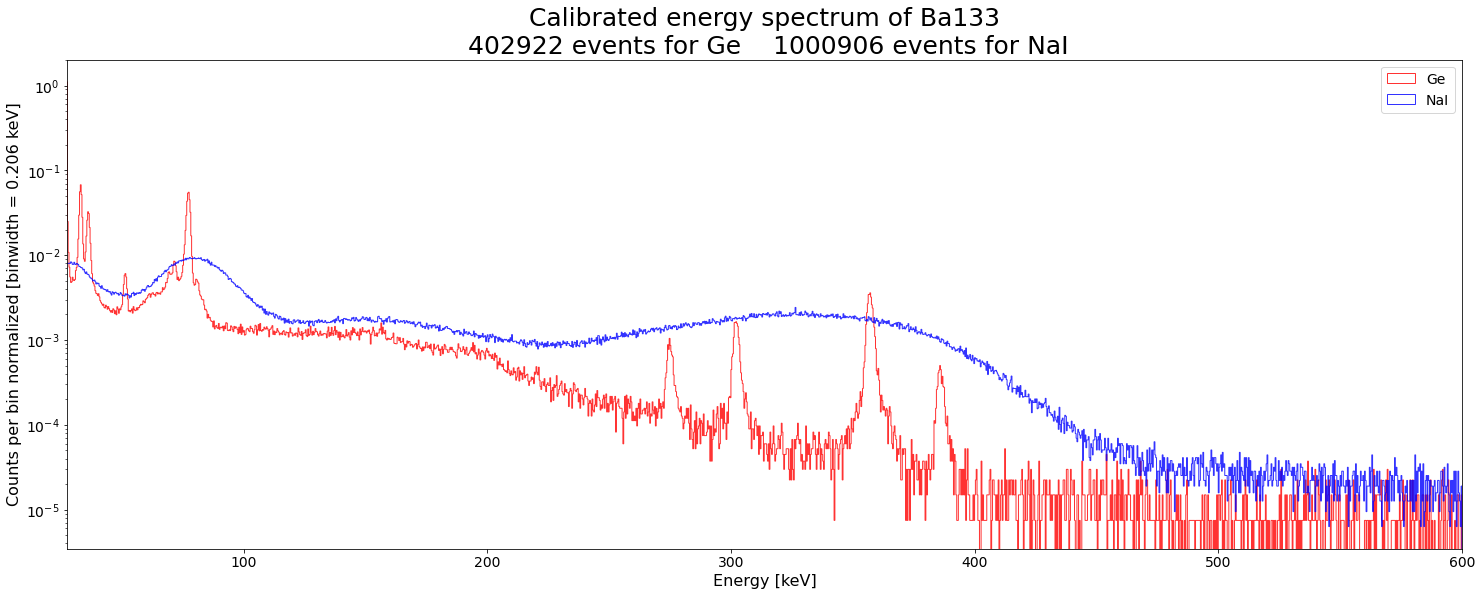

In [ ]:
##don't run this !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#
#calibrated_data_ge=calibrated_data
#info_ge=info
#
#calibrated_data_nai=calibrated_data
#info_nai=info
#

source_to_plot="Ba133"  # CHANGE ONLY THIS
thr_to_plot_ge="30001"
thr_to_plot_nai="10000"
detector_to_calibrate="Ge"

plt.figure(figsize=(25,9))
plt.hist(calibrated_data_ge[info_ge[source_to_plot+thr_to_plot_ge]],bins=info_ge[source_to_plot+"_bins"],color="red",range=info_nai[source_to_plot+"_range_cal"],alpha=0.8,histtype="step",label="Ge",density=True)
plt.hist(calibrated_data_nai[info_nai[source_to_plot+thr_to_plot_nai]],bins=info_ge[source_to_plot+"_bins"],color="blue",range=info_nai[source_to_plot+"_range_cal"],alpha=0.8,histtype="step",label="NaI",density=True)

binwidth_cal=(info_ge[source_to_plot+"_range_cal"][1]-info_ge[source_to_plot+"_range_cal"][0])/info_ge[source_to_plot+"_bins"]

plt.legend(fontsize=14)

plt.xlim(0,info[source_to_plot+"_range_cal"][1])
plt.yscale("log")
print("\n\n")

plt.title(" Calibrated energy spectrum of {:s} \n {:d} events for Ge    {:d} events for NaI".format(source_to_plot,len(calibrated_data_ge[info_ge[source_to_plot+thr_to_plot_ge]]),len(calibrated_data_nai[info_nai[source_to_plot+thr_to_plot_nai]])),fontsize=25)
plt.xlabel("Energy [keV]",fontsize=16)
plt.ylabel("Counts per bin normalized [binwidth = {:.3f} keV]".format(binwidth_cal),fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(27.5,600)
###plt.ylim(0,10000)
##plt.savefig(data_dir_comp+"/Plots/"+source_to_plot+"_cal.png")
#
##plt.show()
#
plt.savefig(path_to_plots+"Ge_NaI_Ba133_spectrum_normalized.png")

In [ ]:
sigma_residuals=np.sqrt(E_unc_Sigma+covar[0][0]*E_real_peaks**2+covar[1][1])/np.sqrt(E_unc_Sigma)
residuals=(E_unc_Mu-parabolic(E_real_peaks,*best_vals))/np.sqrt(E_unc_Sigma)



print("Res: ",residuals)
print("Sigma_Res: ",sigma_residuals)

chi=0
for res,sigma_res in zip(residuals,sigma_residuals):
  chi+=abs(res)


print("\n\nChi^2: {:.3f}".format(chi))

Res:  [ 4.52636089  2.79754189 -4.69424839 -9.6119078  -2.52787845 -0.71022096
  3.01624714  4.63867571  4.33066665 -0.0496528  -1.75616885]
Sigma_Res:  [1.00038207 1.00037346 1.00032017 1.00043405 1.00034839 1.0003844
 1.00035211 1.00034978 1.00053466 1.0003204  1.00047525]


Chi^2: 38.660


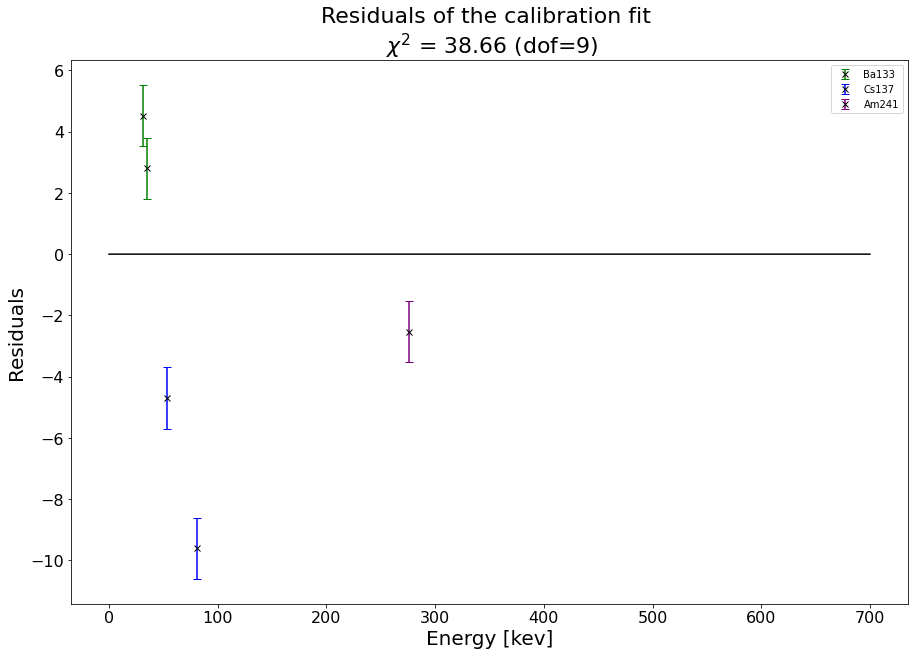

In [ ]:
plt.figure(figsize=(15,10))
sigma_residuals=[1]*len(E_real_peaks)
plt.errorbar(E_real_peaks[0:2],residuals[0:2],yerr=sigma_residuals[0:2],fmt="x",ecolor="green",capsize=4,color="black",label="Ba133")
plt.errorbar(E_real_peaks[2:4],residuals[2:4],yerr=sigma_residuals[2:4],fmt="x",ecolor="blue",capsize=4,color="black",label="Cs137")
plt.errorbar(E_real_peaks[4:5],residuals[4:5],yerr=sigma_residuals[4:5],fmt="x",ecolor="purple",capsize=4,color="black",label="Am241")
#plt.errorbar(E_real_peaks[3:4],residuals[3:4],yerr=sigma_residuals[3:4],fmt="x",ecolor="green",capsize=4,color="black")
#plt.errorbar(E_real_peaks[4:5],residuals[4:5],yerr=sigma_residuals[4:5],fmt="x",ecolor="blue",capsize=4,color="black")
#plt.errorbar(E_real_peaks[5:6],residuals[5:6],yerr=sigma_residuals[5:6],fmt="x",ecolor="blue",capsize=4,color="black")
#
#plt.plot(E_real_peaks,residuals,ls="",marker="x",color="red")
#plt.errorbar(E_real_peaks,residuals,yerr=sigma_residuals,fmt="x",ecolor="blue",capsize=4,color="black")

energy_axis=np.linspace(0,end_range,5000)

plt.plot(energy_axis,[0]*len(energy_axis),color="black")
#plt.yticks(np.linspace(-5,5,11),np.linspace(-5,5,11))
#plt.ylim(-5.5,5.5)

plt.title("Residuals of the calibration fit \n $\chi^2$ = {:.2f} (dof={:d})".format(chi,len(residuals)-2),fontsize=22)
plt.xlabel("Energy [kev]",fontsize=20)
plt.ylabel("Residuals",fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend()


#plt.show()

#plt.savefig(path_to_plots+"residuals_Ba_Cs_Am_NaI.png")

In [ ]:
for source,thr in zip(sources_to_calibrate_base,thresholds_to_calibrate_base):
  print(source, "\t  ", thr)

Ba133 	   10000
Na22 	   10000
Co60 	   10000


In [ ]:
nomefile=path_to_calibration+"/Ba133_THR_30001_all_integrals.txt"
f=open(nomefile,"r")
lines=f.readlines() #leggo linee del file
colonna1=[]
for riga in lines:
  colonna1.append(riga.split()[0])
f.close()

info["Ba13330001"]=1

all_integrals_values = np.asarray(colonna1, dtype=np.float64)
calibrated_data[info["Ba13330001"]]=all_integrals_values

In [ ]:
calibrated_data

{0: array([329.57408608, 454.20643545,  32.67632441, ...,  68.47936295,
        183.03200035, 433.40977878]),
 1: array([76.99179974, 27.60350226, 76.87572033, ..., 27.60350226,
        34.8346842 , 27.60350226])}

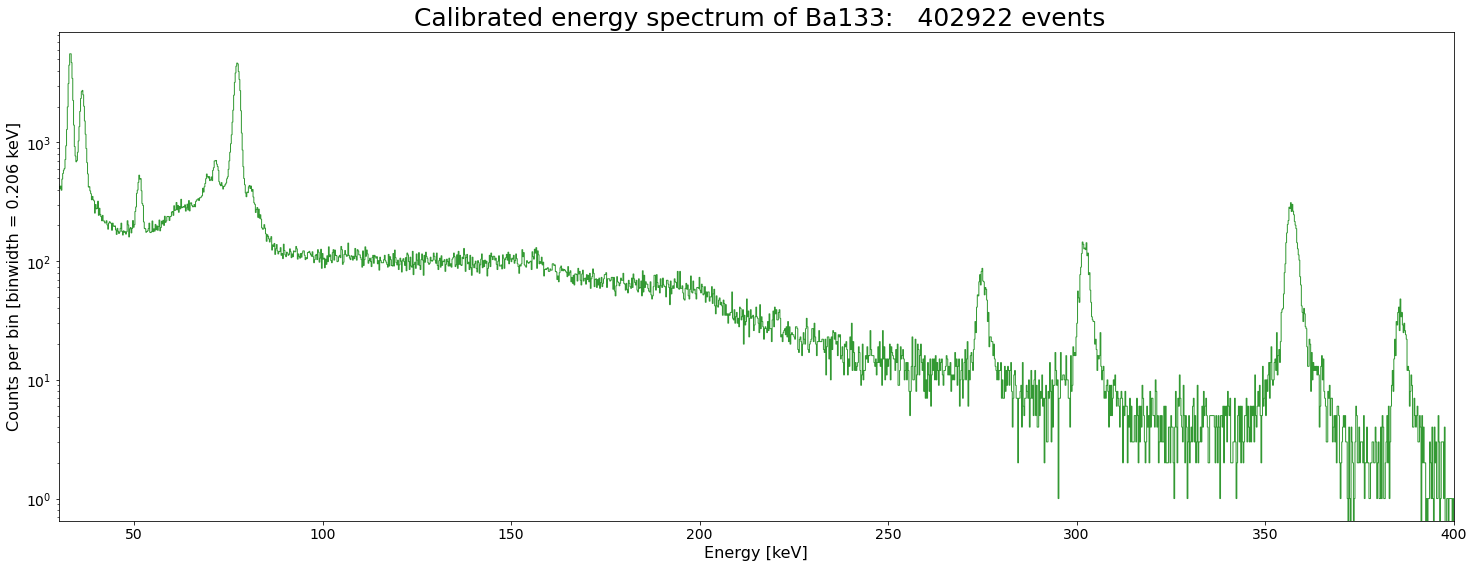

In [ ]:
source_to_plot="Ba133"  # CHANGE ONLY THIS
thr_to_plot="30001"
detector_to_calibrate="Ge"

plt.figure(figsize=(25,9))
plt.hist(calibrated_data[info[source_to_plot+thr_to_plot]],bins=info[source_to_plot+"_bins"],color=info[source_to_plot+"_col"],range=info[source_to_plot+"_range_cal"],alpha=0.8,histtype="step")

ticks_peaks=[]
for source in sources_to_calibrate_base:
  for peak in peaks[source+"_cal"]:
    ticks_peaks.append(peak)

#plt.xticks(ticks_peaks,label=ticks_peaks,color="black",rotation=70,fontsize=14)

binwidth_cal=(info[source_to_plot+"_range_cal"][1]-info[source_to_plot+"_range_cal"][0])/info[source_to_plot+"_bins"]


plt.xlim(7,info[source_to_plot+"_range_cal"][1])
plt.yscale("log")
print("\n\n")

plt.title(" Calibrated energy spectrum of {:s}:   {:d} events".format(source_to_plot,len(calibrated_data[info[source_to_plot+thr_to_plot]])),fontsize=25)
plt.xlabel("Energy [keV]",fontsize=16)
plt.ylabel("Counts per bin [binwidth = {:.3f} keV]".format(binwidth_cal),fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(30,400)

#plt.savefig(data_dir_comp+"/Plots/"+source_to_plot+"_cal.png")

#plt.show()

#plt.savefig(path_to_plots+"Cal_spectrum_Ba133_Ge.png")

**FANO GERMANIUM DETECTOR**

In [ ]:
E_unc_Sigma=np.array(E_unc_Sigma)/multiplication_cheat

In [ ]:
init_vals_fano = [0.1,1]

first_point=1

# (all_mu-linear(E_real_peaks,best_vals[0],best_vals[1]))//np.sqrt(all_sigmaMu)
#err_fano=np.sqrt(   (((2*all_sigma)**2)*all_sigmaSigma+((2*best_vals[1])**2)*covar[1][1])/best_vals[0]**2 + (2*((abs(all_sigma)-best_vals[1])/best_vals[0]**3))**2  )/E_real_peaks


#R=(abs(all_sigma)-best_vals[1])/(all_mu - best_vals[1])

#err_rel_num=np.sqrt(all_sigmaSigma+covar[1][1])/(abs(all_sigma)-best_vals[1])
#err_rel_den=np.sqrt(all_sigmaMu+covar[0][0])/(all_mu - best_vals[1])



R=abs(E_unc_Sigma)/(E_unc_Mu )

print(R**2)

err_rel_num=np.sqrt(E_unc_sigmaSigma)/(abs(E_unc_Sigma))
err_rel_den=np.sqrt(E_unc_sigmaMu)/(E_unc_Mu )

err_R=(err_rel_num+err_rel_den)*R

err_fano=2*err_R*R

params_bound=([0,0],[np.inf,np.inf])

calibrated_mu=(E_unc_Mu - best_vals[1])/best_vals[0]

best_vals_fano, covar_fano = curve_fit(fano, E_real_peaks[first_point:], R[first_point:]**2,sigma=err_fano[first_point:],p0=init_vals_fano,bounds=params_bound)

x_fano=np.linspace(0,1400,10000)

plt.figure(figsize=(15,10))





#plt.plot(E_real_peaks,(abs(all_sigma)-best_vals[1])/best_vals[0],ls="",marker="x",markersize=8,color="black") #errore in kev sui picchi
#plt.plot(E_real_peaks,(((abs(all_sigma)-best_vals[1])/best_vals[0])/E_real_peaks)**2,ls="",marker="x",markersize=8,color="black") #errore percentuale sui picchi
plt.errorbar(E_real_peaks[first_point:4],R[first_point:4]**2,yerr=err_fano[first_point:4],fmt="x",ecolor="green",capsize=4,color="green",label="Ba133")
plt.errorbar(E_real_peaks[4:5],R[4:5]**2,yerr=err_fano[4:5],fmt="x",ecolor="red",capsize=4,color="red",label="Na22")
plt.errorbar(E_real_peaks[5:],R[5:]**2,yerr=err_fano[5:],fmt="x",ecolor="purple",capsize=4,color="purple",label="Co60")
plt.legend()

plt.plot(x_fano[first_point:],fano(x_fano[first_point:],*best_vals_fano),color="blue")
plt.ylabel("R^2",fontsize=16)
plt.xlabel("Energy [keV]",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(5,1400)
plt.ylim(-0.000001,0.0001)
print("S: ",best_vals_fano[0], "sigma_S:",np.sqrt(covar_fano[0][0]))
print("n_e: ",abs(best_vals_fano[1]), "sigma_n_e:",np.sqrt(covar_fano[1][1]))
print("Fano: ",best_vals_fano[0]/2.96e-3, "sigma_Fano:",np.sqrt(covar_fano[0][0])/2.96e-3)

plt.title("Fano factor: \n Fano=({:.2f} $\pm$ {:.2f}) \n n$_e$=({:.2f} $\pm$ {:.2f})".format(best_vals_fano[0]/2.96e-3,np.sqrt(covar_fano[0][0])/2.96e-3,abs(best_vals_fano[1]),np.sqrt(covar_fano[1][1])),fontsize=20)


#plt.savefig(path_to_plots+"Fano_Ba_Co_Na_gain10.png")

NameError: ignored

In [ ]:
use_fit_params_old=True
gain=30

if use_fit_params_old==True:
  best_vals_fano=[0,0]
  err_best_vals_fano=[0,0]
#value from the fit with the plot on the drive   ##### NAI #####
if detector_to_calibrate=="Ge" and use_fit_params_old==True and gain==30:
  best_vals_fano[0]=0.00281097618828865
  best_vals_fano[1]=0.6949806644298442
  err_best_vals_fano=[0.0005750126714064387,0.18425527394530447]
elif detector_to_calibrate=="Ge" and use_fit_params_old==True and gain==10:
  best_vals_fano[0]=0.2*2.96e-3
  best_vals_fano[1]=1.82
  err_best_vals_fano=[0.12*2.96e-3,0.05]

**SIMULATIONS**

In [ ]:
source_sim="/Ba133"
active_detectors=1  # 1 for One detector   not 1 for All detectors
thr_real_data="30001"



path_to_simulations_source=path_to_simulations+source_sim

if active_detectors==1:
  file_name_sim=source_sim+"_O.root"
else:
  file_name_sim=source_sim+"_A.root"

file_sim = ROOT.TFile.Open(path_to_simulations_source+file_name_sim,"READ")

tree_en=file_sim.Get("Scoring")
numb_of_events=tree_en.GetEntries()
print("There are {:d} events in this simulation run using {:s}".format(numb_of_events,source_sim[1:]))

i=0
energy_values_sim=np.zeros(numb_of_events)

for event in tree_en:
  energy_values_sim[i]=event.fEnergy*1000 # in keV
  i+=1

There are 201339 events in this simulation run using Ba133


Number events real: 402922
Number events sim: 201339


Bin length real: 0.3972
Bin length sim: 0.3961


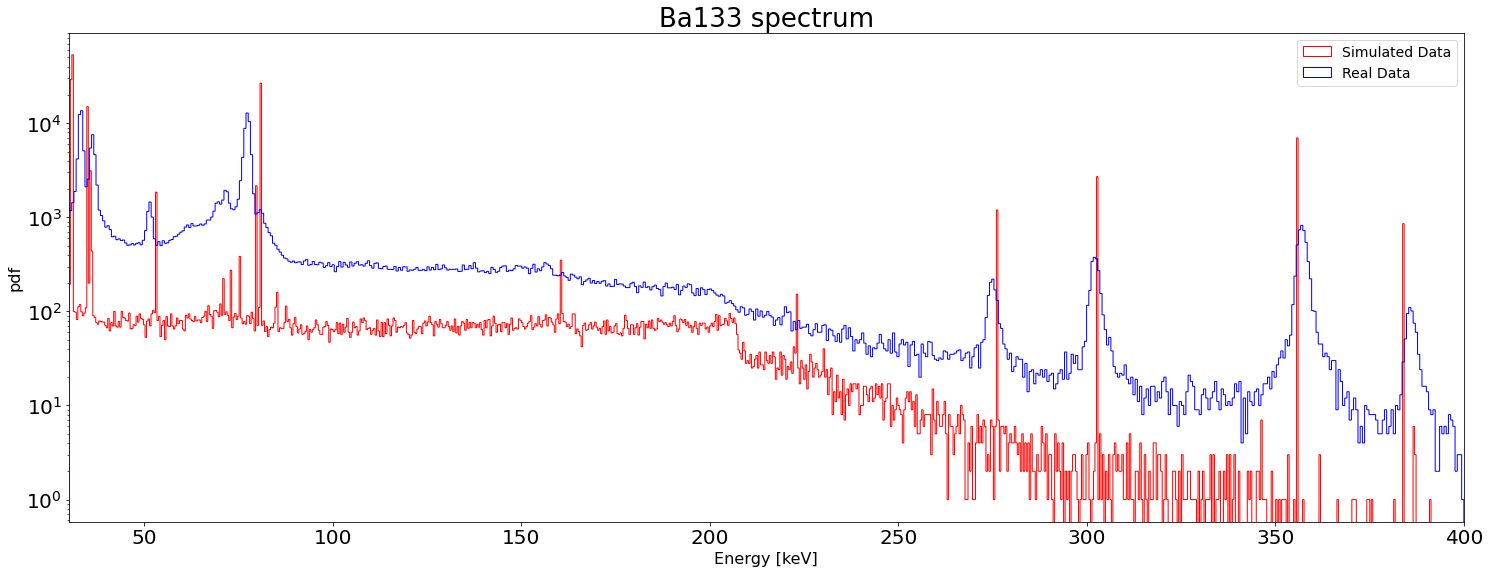

In [ ]:
#numb_bins_sim=real_bins#info[source_sim[1:]+"_bins"]

if source_sim[1:]=="Ba133":
    energy_lim_sx_sim=30
    energy_lim_dx_sim=400
elif source_sim[1:]=="Cs137":
    energy_lim_sx_sim=29
    energy_lim_dx_sim=700
elif source_sim[1:]=="Am241":
    energy_lim_sx_sim=0
    energy_lim_dx_sim=100
elif source_sim[1:]=="Na22":
    energy_lim_sx_sim=93
    energy_lim_dx_sim=1500
elif source_sim[1:]=="Co60":
    energy_lim_sx_sim=130
    energy_lim_dx_sim=info["Co60_range_cal"][1]

range_calibrated_sim=(energy_lim_sx_sim,energy_lim_dx_sim)

real_energy_space=info[source_sim[1:]+"_range_cal"][1]-info[source_sim[1:]+"_range_cal"][0]
real_bins=int(np.sqrt(len(calibrated_data[info[source_sim[1:]+thr_real_data]])))+300
real_events=len(calibrated_data[info[source_sim[1:]+thr_real_data]])
print("Number events real: {:d}".format(real_events))
print("Number events sim: {:d}".format(numb_of_events))


sim_bins=real_bins
sim_energy_space=energy_lim_dx_sim-energy_lim_sx_sim

print("\n\nBin length real: {:.4f}".format(real_energy_space/real_bins))
print("Bin length sim: {:.4f}".format(sim_energy_space/sim_bins))

binwidth_cal=real_energy_space/real_bins

#print(colored("\n\nThere are {:d} events in this simulation run using {:s}","red").format(numb_of_events,source_sim[1:]))
#print(colored("There are {:d} events in this real run using {:s}","blue").format(len(calibrated_data[info[source_sim[1:]+thr_real_data]]),source_sim[1:]))

plt.figure(figsize=(25,9))
plt.hist(energy_values_sim,bins=sim_bins,histtype="step",range=range_calibrated_sim,color="red",label="Simulated Data",density=False)
plt.hist(calibrated_data[info[source_sim[1:]+thr_real_data]],bins=int(np.sqrt(len(calibrated_data[info[source_sim[1:]+thr_real_data]]))),histtype="step",range=info[source_sim[1:]+"_range_cal"],color="blue",label="Real Data",density=False)
plt.yscale("log")

plt.title("{:s} spectrum".format(source_sim[1:]),fontsize=26)
plt.xlabel("Energy [keV]",fontsize=16)
plt.ylabel("pdf",fontsize=16)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=14)

#plt.savefig(path_to_plots+"SIM_Data_spectrum.png")

plt.xlim(energy_lim_sx_sim,energy_lim_dx_sim)

plt.show()

Smearing gaussiano

In [ ]:
S=best_vals_fano[0]
#S=0
n_e=np.sqrt(best_vals_fano[1])
#S=0.2*2.96e-3
#n_e=1

Sigma_E=np.sqrt(S*energy_values_sim+n_e**2)
Energy_offset_simulation=np.random.normal([0]*numb_of_events,Sigma_E,size=numb_of_events)
energy_smeared=energy_values_sim+Energy_offset_simulation

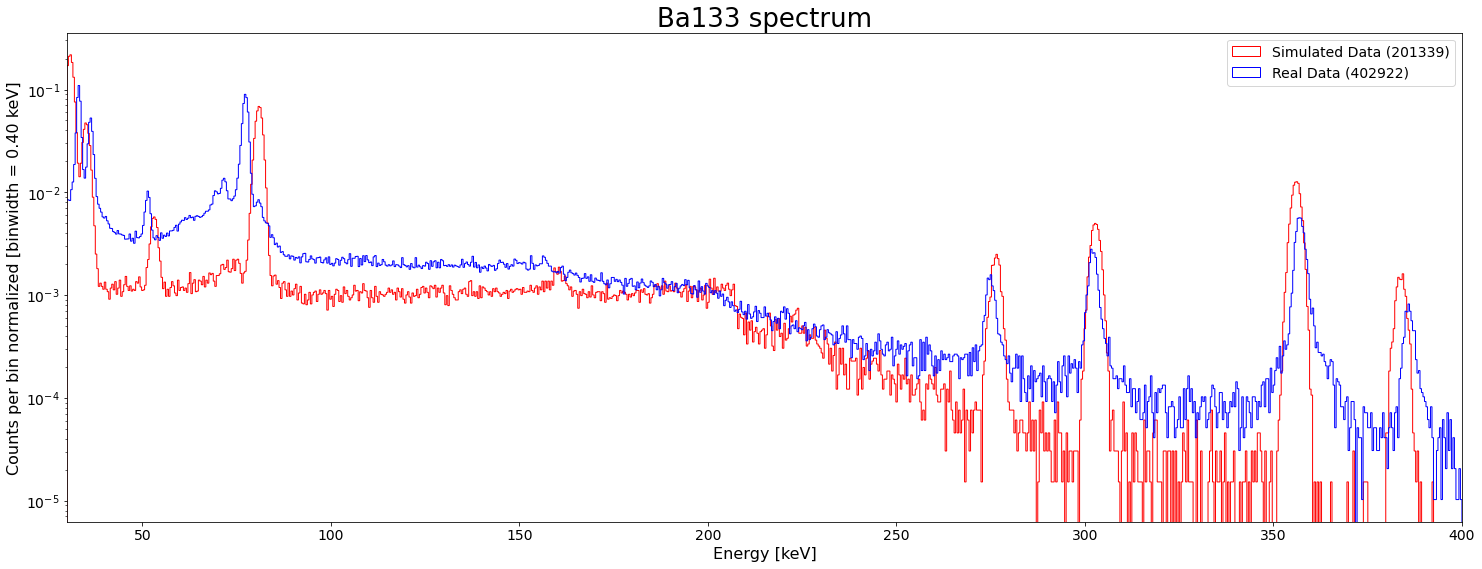

In [ ]:
plt.figure(figsize=(25,9))
plt.hist(energy_smeared,bins=sim_bins,histtype="step",range=range_calibrated_sim,color="red",label="Simulated Data ("+str(numb_of_events)+")",density=True)
plt.hist(calibrated_data[info[source_sim[1:]+thr_real_data]],bins=real_bins,histtype="step",range=info[source_sim[1:]+"_range_cal"],color="blue",label="Real Data ("+str(real_events)+")",density=True)
plt.yscale("log")

#plt.legend(loc=3)

plt.xlim(energy_lim_sx_sim,energy_lim_dx_sim)
#plt.ylim(0,2000)

#labels_list=[str(source_sim[1:])+" spectrum. ","\n\n Real Events: "+str(real_events),"        Simulated Events: "+str(numb_of_events)]
#colors_list=["black","blue","red"]
#color_title(labels_list,colors_list,textprops={"size":26})


plt.title("{:s} spectrum".format(source_sim[1:]),fontsize=26)

plt.xlabel("Energy [keV]",fontsize=16)
plt.ylabel("Counts per bin normalized [binwidth = {:.2f} keV]".format(binwidth_cal),fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

#plt.savefig(path_to_plots+"Ba133_real_sim_normalized.png")

RuntimeError: ignored

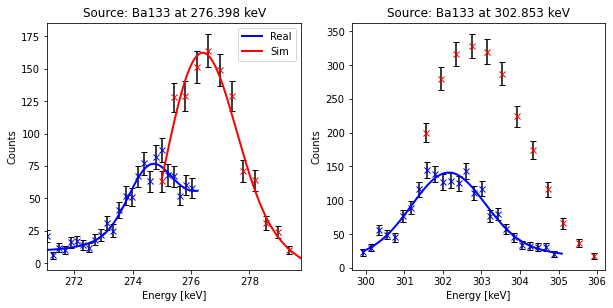

In [ ]:
if source_sim[1:]=="Ba133":
  energy_peaks_real=[274     , 302.853 , 357 ,     386]
  energy_peaks=[    276.398 , 302.853 , 356.017 , 383.851]
elif source_sim[1:]=="Cs137":
  energy_peaks_real=[34,37 , 661.657]
  energy_peaks=[31.817 ,36.194, 661.657]
elif source_sim[1:]=="Co60":
  energy_peaks_real=[1175.237,1334.501]
  energy_peaks=[1173.237,1332.501]
elif source_sim[1:]=="Na22":
  energy_peaks_real=[500]
  energy_peaks=[511]

plt.figure(figsize=(10,10))

n_rows=round((len(energy_peaks)+0.1)/2.)
#n_rows=3
n_cols=2
k=1

mu_real=[]
err_mu_real=[]

sigma_real=[]
err_sigma_real=[]


mu_simulated=[]
err_mu_simulated=[]

sigma_simulated=[]
err_sigma_simulated=[]

for Xpeak_cal,Xpeak_cal_real in zip(energy_peaks,energy_peaks_real):
    z=0
    if source_sim[1:]=="Co60":
      histogram=np.histogram(calibrated_data[info[source_sim[1:]+thr_real_data]],bins=1000,range=(93,1650))
    else:
      histogram=np.histogram(calibrated_data[info[source_sim[1:]+thr_real_data]],bins=info[source_sim[1:]+"_bins"],range=info[source_sim[1:]+"_range_cal"])
    #grandezze legate ai bin
    value1=histogram[0]
    sigma_value1=np.sqrt(value1)
    center_bins1=[0.5*(histogram[1][i]+histogram[1][i+1]) for i in range(len(histogram[1])-1)]
    center_bins1=np.array(center_bins1)

    histogram=np.histogram(energy_smeared,bins=sim_bins,range=range_calibrated_sim)
    #grandezze legate ai bin
    value2=histogram[0]
    sigma_value2=np.sqrt(value2)
    center_bins2=[0.5*(histogram[1][i]+histogram[1][i+1]) for i in range(len(histogram[1])-1)]
    center_bins2=np.array(center_bins2)
    i_sx=4
    i_dx=8
    if source_sim[1:]=="Ba133":
      i_sx_real=[15,6,15,15,30,15,32,30]
      i_dx_real=[10,20,35,35,35,35,35,35]
    elif source_sim[1:]=="Cs137":
      i_sx_real=[7,7,10]
      i_dx_real=[7,10,15]
    elif source_sim[1:]=="Co60":
      i_sx_real=[7,7]
      i_dx_real=[7,5]
    elif source_sim[1:]=="Na22":
      i_sx_real=[7]
      i_dx_real=[7]
    for i in range(len(center_bins1)):
        if(center_bins1[i] > Xpeak_cal_real):
            plt.subplot(n_rows,n_cols,k)
            plt.errorbar(center_bins1[i-i_sx_real[z]:i+i_dx_real[z]],value1[i-i_sx_real[z]:i+i_dx_real[z]],yerr=np.sqrt(value1[i-i_sx_real[z]:i+i_dx_real[z]]),fmt="x",color="Blue",ecolor="black",capsize=3)
            #plt.plot(center_bins[i-best_i_sx[k-1]:i+best_i_dx[k-1]],value[i-best_i_sx[k-1]:i+best_i_dx[k-1]],ls="",marker="x",markersize=8,color="black")
            plt.title("Source: {:s} at {:s} keV".format(source_sim[1:],str(Xpeak_cal)),color="Black")
            plt.xlabel("Energy [keV]")
            plt.ylabel("Counts")

            init_vals = [value1[i],Xpeak_cal_real ,(center_bins1[i+1]-center_bins1[i-1]),0,0,0]
            best_vals_gauss_1, covar_gauss_1 = curve_fit(gaussian_plus_bkg,center_bins1[i-i_sx_real[z]:i+i_dx_real[z]],value1[i-i_sx_real[z]:i+i_dx_real[z]],sigma=np.sqrt(value1[i-i_sx_real[z]:i+i_dx_real[z]]),p0=init_vals)

            mu_real.append(best_vals_gauss_1[1])
            err_mu_real.append(covar_gauss_1[1][1])

            sigma_real.append(best_vals_gauss_1[2])
            err_sigma_real.append(covar_gauss_1[2][2])


            x_gauss=np.linspace(center_bins1[i-i_sx_real[z]],center_bins1[i+i_dx_real[z]],1000)
            plt.plot(x_gauss,gaussian_plus_bkg(x_gauss,*best_vals_gauss_1),color="Blue",lw=2,label="Real")
            z+=1
            #x_gauss=np.linspace(center_bins1[i-i_sx],center_bins1[i+i_dx],1000)
            #init_vals = [value[i],Xpeak_unc ,(center_bins[i+1]-center_bins[i-1]),0,0,0]
            #best_vals_gauss, covar_gauss = curve_fit(gaussian_plus_bkg,center_bins[i-i_sx:i+i_dx],value[i-i_sx:i+i_dx],sigma=np.sqrt(value[i-i_sx:i+i_dx]),p0=init_vals)
            #plt.plot(x_gauss,gaussian_plus_bkg(x_gauss,*best_vals_gauss),color="green")
            #plt.plot(x_gauss,gaussian_plus_bkg(x_gauss,*init_vals),color="red")

            min_sx=x_gauss[0]
            max_dx=x_gauss[-1]
            break
    for i in range(len(center_bins2)):
        if(center_bins2[i] > Xpeak_cal):
            plt.subplot(n_rows,n_cols,k)
            plt.errorbar(center_bins2[i-i_sx:i+i_dx],value2[i-i_sx:i+i_dx],yerr=np.sqrt(value2[i-i_sx:i+i_dx]),fmt="x",color="Red",ecolor="black",capsize=3)
            #plt.plot(center_bins[i-best_i_sx[k-1]:i+best_i_dx[k-1]],value[i-best_i_sx[k-1]:i+best_i_dx[k-1]],ls="",marker="x",markersize=8,color="black")
            #plt.title("Source: {:s} at {:s} keV. SIMULATED".format(source,str(Xpeak_cal)),color="Blue")
            #plt.xlabel("Energy [keV]")
            #plt.ylabel("Counts")
            #plt.legend()

            init_vals = [value2[i],Xpeak_cal ,(center_bins2[i+1]-center_bins2[i-1]),value2[i+15],0,0]
            best_vals_gauss_2, covar_gauss_2 = curve_fit(gaussian_plus_bkg,center_bins2[i-i_sx:i+i_dx],value2[i-i_sx:i+i_dx],sigma=np.sqrt(value2[i-i_sx:i+i_dx]),p0=init_vals)

            mu_simulated.append(best_vals_gauss_2[1])
            err_mu_simulated.append(covar_gauss_2[1][1])

            sigma_simulated.append(best_vals_gauss_2[2])
            err_sigma_simulated.append(covar_gauss_2[2][2])

            x_gauss=np.linspace(center_bins2[i-i_sx],center_bins2[i+i_dx],1000)
            plt.plot(x_gauss,gaussian_plus_bkg(x_gauss,*best_vals_gauss_2),color="Red",lw=2,label="Sim")

            if x_gauss[0]<min_sx:
              min_sx=x_gauss[0]

            if x_gauss[-1]>max_dx:
              max_dx=x_gauss[-1]

            plt.xlim(min_sx,max_dx)

            k+=1
            plt.legend()

            break
plt.tight_layout()
#plt.savefig(path_to_plots+"Gaussian_Fits_real_sim_Co60.png")

m: 0.9762682  +/- inf    relative:  inf %


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.]),
 <a list of 9 Text major ticklabel objects>)

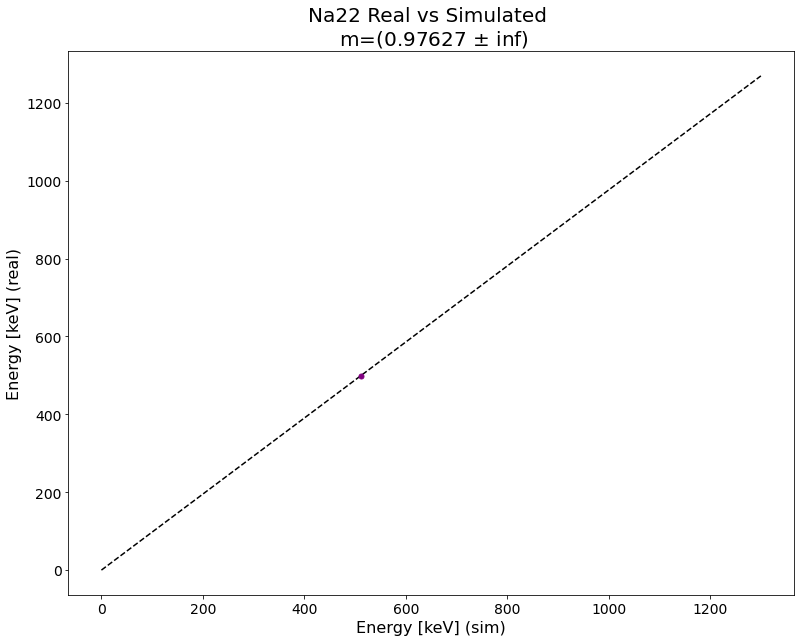

In [ ]:
init_vals = [1]  # for [N,mu, wid]

plt.figure(figsize=(13,10))

def linear_no_q(x,m):
  return m*x

cheat_factor=1

best_vals, covar = curve_fit(linear_no_q,mu_simulated, mu_real,p0=init_vals, sigma=np.sqrt(np.array(err_mu_real)*cheat_factor))

x=np.linspace(0,info[source_sim[1:]+"_range_cal"][1],2000)

plt.plot(x,linear_no_q(x,*best_vals),ls="--",color="black")
plt.errorbar(mu_simulated,mu_real,yerr=np.sqrt(np.array(err_mu_real)*cheat_factor),fmt="o",capsize=0.5,markersize=5,c="purple")

#plt.plot(x,linear_no_q(x,1),ls="-.",color="green")
print("m: {:.7f}  +/- {:.4f}    relative:  {:.4f} %".format(best_vals[0],np.sqrt(covar[0][0]),np.sqrt(covar[0][0])*100/best_vals[0]) )
#print("m: {:.7f}  +/- {:.4f}    relative:  {:.4f} %".format(best_vals[0],0.00792938162,0.00792938162*100/best_vals[0]) )
#print("q: {:.2e}  +/- {:.2e}    relative:  {:.2f} %".format(best_vals[1],np.sqrt(covar[1][1]),np.sqrt(covar[1][1])*100/abs(best_vals[1])) )

plt.xlabel("Energy [keV] (sim)",fontsize=16)
plt.ylabel("Energy [keV] (real)",fontsize=16)

plt.title("{:s} Real vs Simulated \n m=({:.5f} $\pm$ {:.5f})".format(source_sim[1:],best_vals[0],np.sqrt(covar[0][0])),fontsize=20)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.savefig(path_to_plots+"Co60_yx.png")

In [ ]:
mu_real_bario = [33.46463408860, 36.7063051481, 51.84581923292, 77.8558144302, 276.1059670815, 303.524193772, 358.4298938540, 387.485434918]
mu_sim_bario =[30.782382853358882, 30.801261698297097, 53.23571270880515, 80.93527728315779, 276.398, 302.853, 356.017, 383.851]
err_mu_bario =[0.01729994, 0.02923171, 0.02440589, 0.01248002, 0.06678121, 0.1323347, 0.06528646, 0.11737646]

mu_real_cobalto= [1180.408225484289, 1344.0]
mu_sim_cobalto = [1173.232606905603, 1332.501]
err_mu_cobalto= [0.09769993, 0.07569993]

mu_real_sodio= [498.8656491]
mu_sim_sodio = [510.9924425]
err_mu_sodio= [0.07508175]

mu_real_cesio= [33.16984613228535, 36.42543067477261, 661.6979243499424]
mu_sim_cesio = [32.04025934720498, 36.7017176309667, 661.5182874974821]
err_mu_cesio= [0.03722554, 0.05234626, 0.04725722]

In [ ]:
mu_real=[33.464634088602025, 36.70630514816876, 51.845819232928676, 77.85581443028563, 276.10596708153264, 303.5241937720519, 358.42989385402825, 387.4854349189648,33.16984613228535, 36.42543067477261, 661.6979243499424]
mu_sim=[30.782382853358882, 30.801261698297097, 53.23571270880515, 80.93527728315779, 276.398, 302.853, 356.017, 383.851,32.04025934720498, 36.7017176309667, 661.5182874974821]
mu_err=[0.01729994, 0.02923171, 0.02440589, 0.01248002, 0.06678121, 0.1323347, 0.06528646, 0.11737646,0.03722554, 0.05234626, 0.04725722]

In [ ]:
print("mu_real_cobalto=",mu_real,"\n","mu_sim cobalto_=",mu_simulated,"\n","err_mu_cobaltoreal=",np.sqrt(err_mu_real))

In [ ]:
#mu_real,mu_simulated, sigma=np.sqrt(err_mu_real

m: 0.9972232  +/- 0.0065    relative:  0.6480 %


(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,
         800.]), <a list of 10 Text major ticklabel objects>)

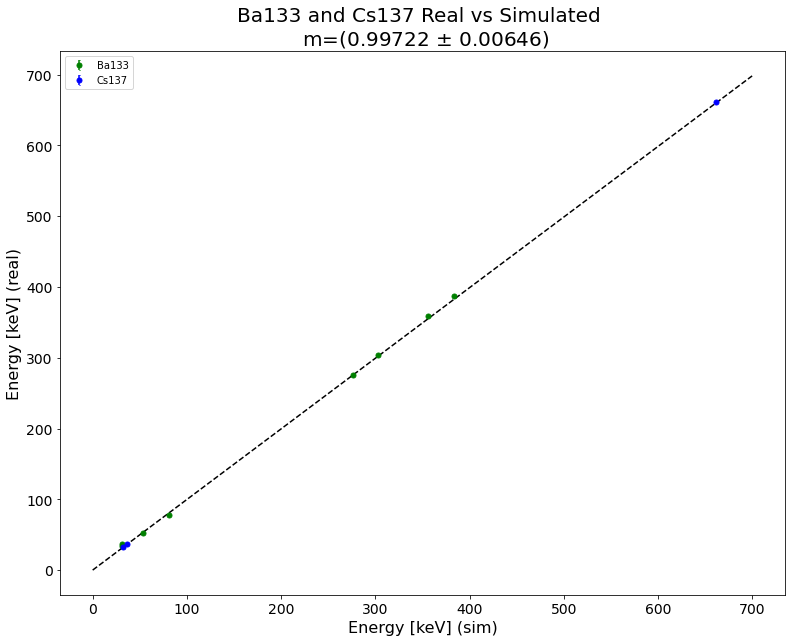

In [ ]:
init_vals = [1]  # for [N,mu, wid]

plt.figure(figsize=(13,10))

def linear_no_q(x,m):
  return m*x

cheat_factor=65

best_vals, covar = curve_fit(linear_no_q,mu_sim, mu_real,p0=init_vals, sigma=mu_err)

x=np.linspace(0,info[source_sim[1:]+"_range_cal"][1],2000)

plt.plot(x,linear_no_q(x,*best_vals),ls="--",color="black")

plt.errorbar(mu_sim_bario,mu_real_bario,yerr=err_mu_bario,fmt="o",capsize=0.5,markersize=5,c="green",label="Ba133")
plt.errorbar(mu_sim_cesio,mu_real_cesio,yerr=err_mu_cesio,fmt="o",capsize=0.5,markersize=5,c="blue",label="Cs137")

#plt.plot(x,linear_no_q(x,1),ls="-.",color="green")
print("m: {:.7f}  +/- {:.4f}    relative:  {:.4f} %".format(best_vals[0],np.sqrt(covar[0][0]),np.sqrt(covar[0][0])*100/best_vals[0]) )
#print("m: {:.7f}  +/- {:.4f}    relative:  {:.4f} %".format(best_vals[0],0.00792938162,0.00792938162*100/best_vals[0]) )
#print("q: {:.2e}  +/- {:.2e}    relative:  {:.2f} %".format(best_vals[1],np.sqrt(covar[1][1]),np.sqrt(covar[1][1])*100/abs(best_vals[1])) )

plt.xlabel("Energy [keV] (sim)",fontsize=16)
plt.ylabel("Energy [keV] (real)",fontsize=16)

plt.title("{:s} and {:s} Real vs Simulated \n m=({:.5f} $\pm$ {:.5f})".format("Ba133","Cs137",best_vals[0],np.sqrt(covar[0][0])),fontsize=20)

plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.savefig(path_to_plots+"Ba133_Cs137_yx.png")

In [ ]:
sigma_residuals=np.sqrt(np.array(mu_err)*cheat_factor+covar[0][0]*np.array(mu_sim)**2)/np.sqrt(np.array(mu_err)*cheat_factor)

residuals=(mu_real-linear_no_q(np.array(mu_sim),*best_vals))/np.sqrt(np.array(mu_err)*cheat_factor)


sigma_residuals_ba=np.sqrt(np.array(err_mu_bario)*cheat_factor+covar[0][0]*np.array(mu_sim_bario)**2)/np.sqrt(np.array(err_mu_bario)*cheat_factor)

residuals_ba=(mu_real_bario-linear_no_q(np.array(mu_sim_bario),*best_vals))/np.sqrt(np.array(err_mu_bario)*cheat_factor)

sigma_residuals_cs=np.sqrt(np.array(err_mu_cesio)*cheat_factor+covar[0][0]*np.array(mu_sim_cesio)**2)/np.sqrt(np.array(err_mu_cesio)*cheat_factor)

residuals_cs=(mu_real_cesio-linear_no_q(np.array(mu_sim_cesio),*best_vals))/np.sqrt(np.array(err_mu_cesio)*cheat_factor)


print("Res: ",residuals)
print("Sigma_Res: ",sigma_residuals)

chi=0
for res,sigma_res in zip(residuals,sigma_residuals):
  chi+=abs(res)


print("\n\nChi^2: {:.3f}".format(chi))

Res:  [ 2.61002271  4.34594757 -0.98614771 -3.16956556  0.22820906  0.51558602
  1.65119711  1.70168339  0.78337214 -0.09453297  1.15057021]
Sigma_Res:  [1.01744304 1.01037217 1.03663215 1.15638585 1.31718863 1.20220665
 1.49911019 1.3440634  1.0088201  1.00823259 2.63618669]


Chi^2: 17.237


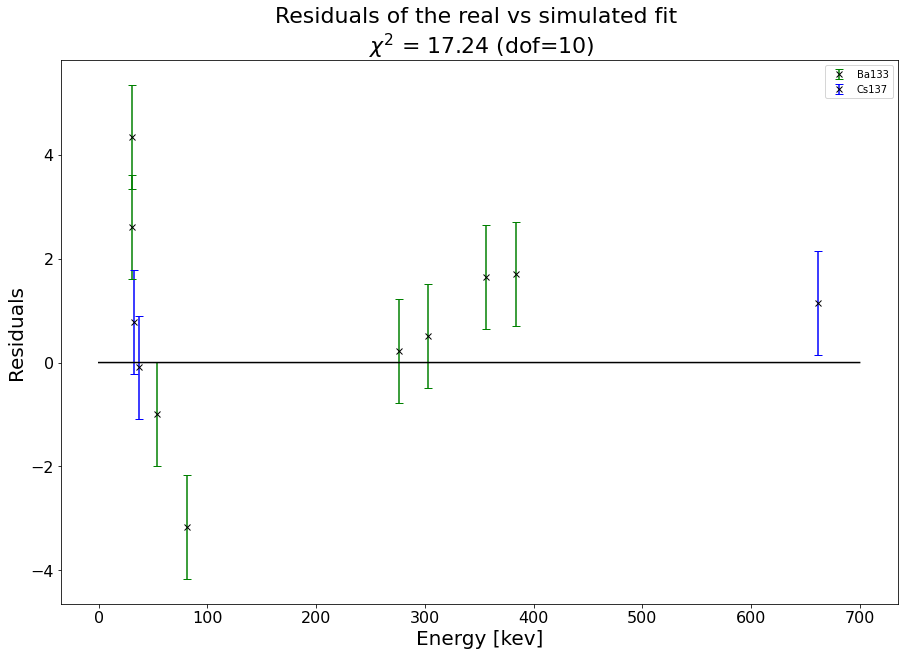

In [ ]:
plt.figure(figsize=(15,10))
sigma_residuals=[1]*len(mu_real)
sigma_residuals_ba=[1]*len(mu_real_bario)
sigma_residuals_cs=[1]*len(mu_real_cesio)
plt.errorbar(mu_sim_bario,residuals_ba,yerr=sigma_residuals_ba,fmt="x",ecolor="green",capsize=4,color="black",label="Ba133")
plt.errorbar(mu_sim_cesio,residuals_cs,yerr=sigma_residuals_cs,fmt="x",ecolor="blue",capsize=4,color="black",label="Cs137")
#plt.errorbar(E_real_peaks[4:5],residuals[4:5],yerr=sigma_residuals[4:5],fmt="x",ecolor="red",capsize=4,color="black",label="Na22")
#plt.errorbar(E_real_peaks[5:],residuals[5:],yerr=sigma_residuals[5:],fmt="x",ecolor="purple",capsize=4,color="black",label="Co60")
#plt.errorbar(E_real_peaks[3:4],residuals[3:4],yerr=sigma_residuals[3:4],fmt="x",ecolor="green",capsize=4,color="black")
#plt.errorbar(E_real_peaks[4:-1],residuals[4:-1],yerr=sigma_residuals[4:-1],fmt="x",ecolor="green",capsize=4,color="black")
#plt.errorbar(E_real_peaks[-1:],residuals[-1:],yerr=sigma_residuals[-1:],fmt="x",ecolor="blue",capsize=4,color="black")
#
#plt.plot(E_real_peaks,residuals,ls="",marker="x",color="red")
energy_axis=np.linspace(0,energy_lim_dx_sim,5000)
plt.plot(energy_axis,[0]*len(energy_axis),color="black")
#plt.yticks(np.linspace(-5,5,11),np.linspace(-5,5,11))
#plt.ylim(-5.5,5.5)

plt.title("Residuals of the real vs simulated fit \n $\chi^2$ = {:.2f} (dof={:d})".format(chi,len(residuals)-1),fontsize=22)
plt.xlabel("Energy [kev]",fontsize=20)
plt.ylabel("Residuals",fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend()


#plt.show()

#plt.savefig(path_to_plots+"residuals_Ba133_Cs137_g30_yx.png")

In [ ]:
sigma_residuals=np.sqrt(np.array(err_mu_real)*cheat_factor+covar[0][0]*np.array(mu_simulated)**2)/np.sqrt(np.array(err_mu_real)*cheat_factor)

residuals=(mu_real-linear_no_q(np.array(mu_simulated),*best_vals))/np.sqrt(np.array(err_mu_real)*cheat_factor)



print("Res: ",residuals)
print("Sigma_Res: ",sigma_residuals)

chi=0
for res,sigma_res in zip(residuals,sigma_residuals):
  chi+=abs(res)


print("\n\nChi^2: {:.3f}".format(chi))

In [ ]:
plt.figure(figsize=(15,10))
sigma_residuals=[1]*len(mu_real)
plt.errorbar(mu_simulated,residuals,yerr=sigma_residuals,fmt="x",ecolor="purple",capsize=4,color="black",label="Cs137")
#plt.errorbar(E_real_peaks[4:5],residuals[4:5],yerr=sigma_residuals[4:5],fmt="x",ecolor="red",capsize=4,color="black",label="Na22")
#plt.errorbar(E_real_peaks[5:],residuals[5:],yerr=sigma_residuals[5:],fmt="x",ecolor="purple",capsize=4,color="black",label="Co60")
#plt.errorbar(E_real_peaks[3:4],residuals[3:4],yerr=sigma_residuals[3:4],fmt="x",ecolor="green",capsize=4,color="black")
#plt.errorbar(E_real_peaks[4:-1],residuals[4:-1],yerr=sigma_residuals[4:-1],fmt="x",ecolor="green",capsize=4,color="black")
#plt.errorbar(E_real_peaks[-1:],residuals[-1:],yerr=sigma_residuals[-1:],fmt="x",ecolor="blue",capsize=4,color="black")
#
#plt.plot(E_real_peaks,residuals,ls="",marker="x",color="red")
energy_axis=np.linspace(0,energy_lim_dx_sim,5000)
plt.plot(energy_axis,[0]*len(energy_axis),color="black")
#plt.yticks(np.linspace(-5,5,11),np.linspace(-5,5,11))
#plt.ylim(-5.5,5.5)

plt.title("Residuals of the real vs simulated fit \n $\chi^2$ = {:.2f} (dof={:d})".format(chi,len(residuals)-1),fontsize=22)
plt.xlabel("Energy [kev]",fontsize=20)
plt.ylabel("Residuals",fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend()


#plt.show()

#plt.savefig(path_to_plots+"residuals_Co60_yx.png")